In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(10)

In [31]:
data = load_breast_cancer()
X = data.data
y = data.target

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Split the train+val set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.2 * 0.75 = 0.15

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [33]:
class AdaBoost:
    def __init__(self, n_estimators, max_depth):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.alphas = []

    def fit(self, X, y, early_stopping_rounds=10):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples
        
        best_error = float('inf')
        rounds_no_improve = 0

        for i in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=10 , criterion='gini')
            model.fit(X, y, sample_weight=w)
            
            predictions = model.predict(X)
            err = np.sum(w * (predictions != y)) / np.sum(w)
            
            if err == 0:
                print(f"Perfect fit achieved at iteration {i}. This may indicate a problem.")
                break
            
            if err >= 0.5:
                print(f"Error >= 0.5 at iteration {i}. Stopping early.")
                break
            
            alpha = 0.5 * np.log((1 - err) / err)
            w *= np.exp(alpha * (predictions != y))
            w /= np.sum(w)
            
            self.models.append(model)
            self.alphas.append(alpha)
            
            # Early stopping check
            if err < best_error:
                best_error = err
                rounds_no_improve = 0
            else:
                rounds_no_improve += 1
                if rounds_no_improve >= early_stopping_rounds:
                    print(f"Early stopping triggered at iteration {i}")
                    break

    def predict(self, X):
        n_samples = X.shape[0]
        class_predictions = np.zeros((n_samples, 2))  # Assuming binary classification
        
        for alpha, model in zip(self.alphas, self.models):
            predictions = model.predict(X)
            class_predictions[np.arange(n_samples), predictions.astype(int)] += alpha
        
        return np.argmax(class_predictions, axis=1)


In [34]:
# Hyperparameter tuning
n_estimators_range = range(5, 156, 10)
max_depth_range = range(1, 27, 5)

best_accuracy = 0
best_n_estimators = 0
best_max_depth = 0
accuarcies = []
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        state_accuarcies = []
        for seed in range(10,110,10):
            model = AdaBoost(n_estimators=n_estimators, max_depth=max_depth)
            model.fit(X_train_scaled, y_train)
            y_pred_val = model.predict(X_val_scaled)
            accuracy = accuracy_score(y_val, y_pred_val)
            state_accuarcies.append(accuracy)
        
        
        mean_accuracy = np.mean(state_accuarcies) 
        accuarcies.append(mean_accuracy)
       # print(f"n_estimators={n_estimators}, max_depth={max_depth}, validation accuracy: {accuracy}")
        
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_n_estimators = n_estimators
            best_max_depth = max_depth
print(f"\nBest hyperparameters: n_estimators={best_n_estimators}, max_depth={best_max_depth}")
print(f"Best validation accuracy: {best_accuracy}")

Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fi

In [35]:
# Train final model with best hyperparameters
best_model = AdaBoost(n_estimators=best_n_estimators, max_depth=best_max_depth)
best_model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_test = best_model.predict(X_test_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average=None)
test_recall = recall_score(y_test, y_pred_test, average=None)
test_f1 = f1_score(y_test, y_pred_test, average=None)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate overall metrics
overall_precision = precision_score(y_test, y_pred_test, average='weighted')
overall_recall = recall_score(y_test, y_pred_test, average='weighted')
overall_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("\nOverall Test Set Metrics:")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Test Set Metrics:
Accuracy: 0.972027972027972
Precision: [0.98076923 0.96703297]
Recall: [0.94444444 0.98876404]
F1 Score: [0.96226415 0.97777778]

Confusion Matrix:
[[51  3]
 [ 1 88]]

Overall Test Set Metrics:
Overall Precision: 0.972220087604703
Overall Recall: 0.972027972027972
Overall F1 Score: 0.9719194851270323


Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.


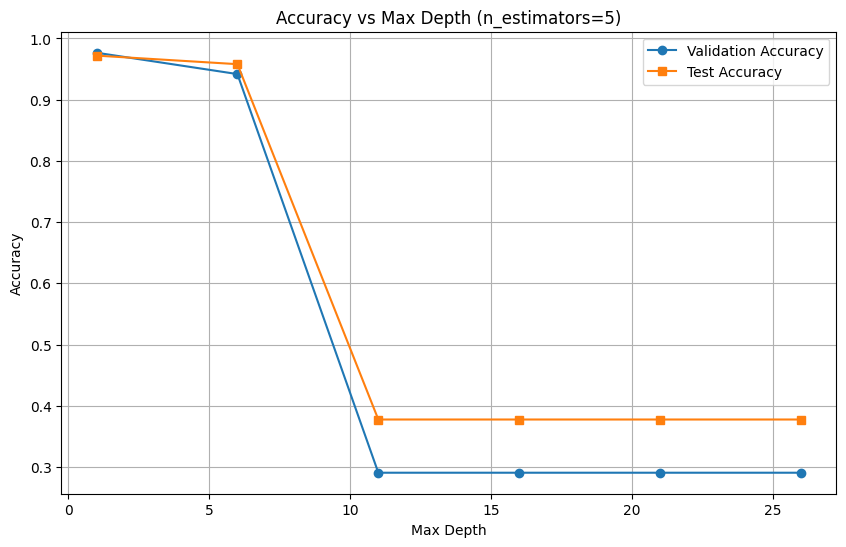


Validation Accuracies: [0.9767441860465116, 0.9418604651162791, 0.29069767441860467, 0.29069767441860467, 0.29069767441860467, 0.29069767441860467]
Test Accuracies: [0.972027972027972, 0.958041958041958, 0.3776223776223776, 0.3776223776223776, 0.3776223776223776, 0.3776223776223776]


In [36]:
# Create lists to store results
max_depths = np.arange(1, 27, 5)
val_accuracies = []
test_accuracies = []

# Iterate over max_depths
for max_depth in max_depths:
    # Create and fit the model
    model = AdaBoost(n_estimators=best_n_estimators,max_depth=max_depth)
    model.fit(X_train_scaled, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(val_acc)
    
    # Calculate test accuracy
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_acc)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(max_depths, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(max_depths, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Max Depth (n_estimators={best_n_estimators})')
plt.legend()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA04AAAIjCAYAAAA0vUuxAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAACYiklEQVR4nOzdd3xUVfrH8c/MpFdKEhIgEJp0EoiIqAgiHSkWwEpRcdeVtbD+VFYF0VVXF3Dt7ro0FQQLTVEkoqgoigIJIEU6GBJCKKmkzdzfH0NGhtQJSSbl+3695jV37j3nzjPDMebJufc5JsMwDERERERERKREZncHICIiIiIiUtMpcRIRERERESmDEicREREREZEyKHESEREREREpgxInERERERGRMihxEhERERERKYMSJxERERERkTIocRIRERERESmDEicREREREZEyKHESERFxQb9+/ejSpctFnSMzM5OwsDAWLVpUSVFVv0OHDmEymViwYIG7Q6mTHnvsMXr16uXuMETkPEqcRKTKvPHGG5hMJv3Pv4ZZsGABJpMJk8nEhg0bihw3DIPIyEhMJhPXXXddtcfXr18/R3xms5mgoCDat2/PHXfcQVxcXLXEcOzYMZ566ini4+Or5Pwvv/wygYGB3HzzzVVy/sq0ePFi/v3vf7s7DCdV/e9TlaKiohzj+/zHn//8Z6d2Dz74IAkJCaxatcpNkYrIhTzcHYCI1F2LFi0iKiqKTZs2sW/fPtq2bevukOQ8Pj4+LF68mKuuuspp/zfffMPvv/+Ot7e3myKD5s2b8/zzzwOQlZXFvn37WLZsGe+99x5jx47lvffew9PTs8re/9ixY8ycOZOoqChiYmIq9dz5+fm8/PLLPPTQQ1gslko9d1VYvHgxO3bs4MEHH3Ta37JlS86ePVul/w4lqcp/n+oQExPD3/72N6d9l1xyidPr8PBwRo0axaxZsxg5cmR1hiciJVDiJCJV4uDBg/zwww8sW7aMP/3pTyxatIgZM2a4O6xiZWVl4e/v7+4wqt2wYcP48MMPeeWVV/Dw+ON/B4sXLyY2NpbU1FS3xRYcHMztt9/utO+f//wn999/P2+88QZRUVG88MILboru4nz66aecOHGCsWPHujuUi2IymfDx8XF3GJWqun4WNGvWrMj4Ls7YsWMZM2YMBw4coHXr1lUel4iUTpfqiUiVWLRoEQ0bNmT48OHcdNNNJd7LcebMGR566CGioqLw9vamefPmjB8/3umX9pycHJ566ikuueQSfHx8iIiI4IYbbmD//v0ArF+/HpPJxPr1653OXdw9GBMnTiQgIID9+/czbNgwAgMDue222wD47rvvGDNmDC1atMDb25vIyEgeeughzp49WyTu3bt3M3bsWEJDQ/H19aV9+/Y8/vjjAHz99deYTCaWL19epN/ixYsxmUxs3Lix2O/jl19+wWQysXDhwiLHvvjiC0wmE59++ikAGRkZPPjgg47vLiwsjIEDB7Jly5Ziz32hW265hZMnTzpd/paXl8dHH33ErbfeWmyfWbNmccUVV9C4cWN8fX2JjY3lo48+cmozf/58TCYT8+bNc9r/3HPPYTKZ+Oyzz8oV34UsFguvvPIKnTp14rXXXiMtLc3p+HvvvUdsbCy+vr40atSIm2++maNHjzq1Kbw/afPmzVxxxRX4+vrSqlUr3nrrLUeb9evX07NnTwAmTZrkuJTqwnt5du7cyTXXXIOfnx/NmjXjxRdfLNfnWLFiBVFRUbRp08Zpf+HYTExMZPTo0QQEBBAaGsrDDz+M1Wot79fk8NNPPzFkyBCCg4Px8/Ojb9++fP/9905tyhpD/fr1Y/Xq1Rw+fNjxPURFRQGl//d15MgRrrvuOgICAmjWrBmvv/46ANu3b6d///74+/vTsmVLFi9e7BTPqVOnePjhh+natSsBAQEEBQUxdOhQEhISHG3K8+/z4YcfOsZCSEgIt99+O4mJicV+38X9LNi7dy833ngj4eHh+Pj40Lx5c26++eYiY+5i5OXlkZWVVWqbAQMGALBy5cpKe18RqTglTiJSJRYtWsQNN9yAl5cXt9xyC3v37uXnn392apOZmUmfPn149dVXGTRoEC+//DJ//vOf2b17N7///jsAVquV6667jpkzZxIbG8vs2bN54IEHSEtLY8eOHRWKraCggMGDBxMWFsasWbO48cYbAfsvW9nZ2dx77728+uqrDB48mFdffZXx48c79d+2bRu9evXiq6++YvLkybz88suMHj2aTz75BLD/shkZGVlssrho0SLatGlD7969i43t0ksvpXXr1nzwwQdFji1dupSGDRsyePBgAP785z/z5ptvcuONN/LGG2/w8MMP4+vry65du8r1PURFRdG7d2/ef/99x77PP/+ctLS0Eu+9efnll+nevTtPP/00zz33HB4eHowZM4bVq1c72kyaNInrrruOqVOnOhKX7du3M3PmTO666y6GDRtWrviKY7FYuOWWW8jOzna6P+vZZ59l/PjxtGvXjjlz5vDggw+ybt06rr76as6cOeN0jtOnTzNs2DBiY2N58cUXad68Offee68j0evYsSNPP/00APfccw/vvvsu7777LldffbXTOYYMGUJ0dDSzZ8+mQ4cOPProo3z++edlfoYffviBHj16FHvMarUyePBgGjduzKxZs+jbty+zZ8/mv//9r0vf01dffcXVV19Neno6M2bM4LnnnuPMmTP079+fTZs2OdqVNYYef/xxYmJiCAkJcXwPZd3vZLVaGTp0KJGRkbz44otERUUxZcoUFixYwJAhQ7j00kt54YUXCAwMZPz48Rw8eNDR98CBA6xYsYLrrruOOXPm8H//939s376dvn37cuzYMaDsf58FCxYwduxYLBYLzz//PJMnT2bZsmVcddVVRcZCcT8L8vLyGDx4MD/++CN//etfef3117nnnns4cOCAU/+0tDRSU1PLfGRmZhb77+Pn50dAQABRUVG8/PLLxX6XwcHBtGnTpkjCKyJuYoiIVLJffvnFAIy4uDjDMAzDZrMZzZs3Nx544AGndtOnTzcAY9myZUXOYbPZDMMwjHnz5hmAMWfOnBLbfP311wZgfP31107HDx48aADG/PnzHfsmTJhgAMZjjz1W5HzZ2dlF9j3//POGyWQyDh8+7Nh39dVXG4GBgU77zo/HMAxj2rRphre3t3HmzBnHvpSUFMPDw8OYMWNGkfc537Rp0wxPT0/j1KlTjn25ublGgwYNjDvvvNOxLzg42LjvvvtKPVdx5s+fbwDGzz//bLz22mtGYGCg47OPGTPGuOaaawzDMIyWLVsaw4cPd+p74XeUl5dndOnSxejfv7/T/qSkJKNRo0bGwIEDjdzcXKN79+5GixYtjLS0tDLj69u3r9G5c+cSjy9fvtwAjJdfftkwDMM4dOiQYbFYjGeffdap3fbt2w0PDw+n/X379jUAY/bs2Y59ubm5RkxMjBEWFmbk5eUZhmEYP//8c5Gxc+E53nnnHadzhIeHGzfeeGOpny0/P98wmUzG3/72tyLHCsfm008/7bS/e/fuRmxsbKnnPZ/NZjPatWtnDB482GlMZmdnG61atTIGDhzo2FeeMTR8+HCjZcuWRfaX9t/Xc88959h3+vRpw9fX1zCZTMaSJUsc+3fv3m0ATv895OTkGFartcj7eHt7O30vJf375OXlGWFhYUaXLl2Ms2fPOvZ/+umnBmBMnz69SKwX/izYunWrARgffvhhqd9L4Tgo6zFhwgSnfiNGjDBeeOEFY8WKFcbcuXONPn36GIDxyCOPFPs+gwYNMjp27FhqLCJSPTTjJCKVbtGiRTRp0oRrrrkGsN8LMW7cOJYsWeJ0ydHHH39MdHQ0119/fZFzmEwmR5uQkBD++te/ltimIu69994i+3x9fR3bWVlZpKamcsUVV2AYBlu3bgXgxIkTfPvtt9x55520aNGixHjGjx9Pbm6u02VsS5cupaCgoMx7G8aNG0d+fj7Lli1z7Fu7di1nzpxh3Lhxjn0NGjTgp59+cvwlviLGjh3L2bNn+fTTT8nIyODTTz8t8TI9cP6OTp8+TVpaGn369ClyeWB4eDivv/46cXFx9OnTh/j4eObNm0dQUFCFYy0UEBAA2C8zA1i2bBk2m42xY8c6/aU/PDycdu3a8fXXXzv19/Dw4E9/+pPjtZeXF3/6059ISUlh8+bN5Y7h/H9HLy8vLrvsMg4cOFBqv1OnTmEYBg0bNiyxzYXV1fr06VPmec8XHx/P3r17ufXWWzl58qTj+8jKyuLaa6/l22+/xWazAZUzhopz9913O7YbNGhA+/bt8ff3d7qvq3379jRo0MDps3l7e2M22381sVqtnDx5koCAANq3b1+uS1B/+eUXUlJS+Mtf/uJ0/9Xw4cPp0KGD08xooQt/FgQHBwP2S2Ozs7NLfK/Zs2cTFxdX5uORRx5x6rdq1SoeeeQRRo0axZ133sk333zD4MGDmTNnjmOm/XwNGzZ06/2GIvIHFYcQkUpltVpZsmQJ11xzjdMlOL169WL27NmsW7eOQYMGAbB//37HZXIl2b9/P+3bt3cqXnCxPDw8aN68eZH9R44cYfr06axatYrTp087HSu8t6Hwl7yy1vHp0KEDPXv2ZNGiRdx1112APaG8/PLLy6wuGB0dTYcOHVi6dKmj79KlSwkJCaF///6Odi+++CITJkwgMjKS2NhYhg0bxvjx4126iTw0NJQBAwawePFisrOzsVqt3HTTTSW2//TTT/nHP/5BfHw8ubm5jv3FJbE333wz7733HqtXr+aee+7h2muvLXdcpSm89CkwMBCw349iGAbt2rUrtv2FVd+aNm1apABAYUWzQ4cOcfnll5cZQ/PmzYt85oYNG7Jt27ZyfQbDMIrd7+PjQ2hoaJHzXjgeS7N3714AJkyYUGKbtLQ0GjZsWClj6ELFfYbg4OBiv7Pg4GCnz2az2Xj55Zd54403OHjwoNMfWho3blzmex8+fBiwJ2UX6tChQ5Hy+8X9LGjVqhVTp05lzpw5LFq0iD59+jBy5Ehuv/12R1IFEBsbW2Y85WEymXjooYf44osvWL9+fZE/rBiGcVF/JBKRyqPESUQq1VdffUVSUhJLlixhyZIlRY4vWrTIkThVlpJ+qSjphvrz/6p9ftuBAwdy6tQpHn30UTp06IC/vz+JiYlMnDjR8Rd6V4wfP54HHniA33//ndzcXH788Udee+21cvUdN24czz77LKmpqQQGBrJq1SpuueUWpwRy7Nix9OnTh+XLl7N27Vr+9a9/8cILL7Bs2TKGDh1a7jhvvfVWJk+eTHJyMkOHDqVBgwbFtvvuu+8YOXIkV199NW+88QYRERF4enoyf/78Ijf5A5w8eZJffvkFsBdSsNlsRb73iii8t60wAbXZbJhMJj7//PNiy3sXzlBVppLKiJeUEBVq1KgRJpOpxESoMsqTF47Vf/3rXyWW6i78TiprDJ2vpM9Qnu/sueee48knn+TOO+/kmWeeoVGjRpjNZh588MEK/TdYluJ+FoB9NmnixImsXLmStWvXcv/99/P888/z448/OhKtU6dOkZeXV+Z7+Pr6OiVcxYmMjHSc80KnT58mJCSkPB9HRKqYEicRqVSLFi0iLCzMUUXrfMuWLWP58uW89dZb+Pr60qZNmzILPLRp04affvqJ/Pz8EteLKbzs6cIbvwv/+lwe27dv57fffmPhwoVOxSAuXHC18C/x5SlMcfPNNzN16lTef/99x3o3519qV5px48Yxc+ZMPv74Y5o0aUJ6enqxBRsiIiL4y1/+wl/+8hdSUlLo0aMHzz77rEu/9F5//fX86U9/4scff2Tp0qUltvv444/x8fHhiy++cFrjaf78+cW2v++++8jIyOD5559n2rRp/Pvf/2bq1Knljqs4VquVxYsX4+fn51h/qk2bNhiGQatWrYqshVOcY8eOFSk7/dtvvwE4KsZV1V/4PTw8aNOmjdNsbGUrrNYXFBTkqMpWmrLGUHXOdnz00Udcc801zJ0712n/mTNnnJKHkmJq2bIlAHv27HGanS3cV3i8PLp27UrXrl154okn+OGHH7jyyit56623+Mc//gHADTfcwDfffFPmeSZMmFCkIuOFCmeyL5ypA/vSDtHR0eWOW0Sqju5xEpFKc/bsWZYtW8Z1113HTTfdVOQxZcoUMjIyWLVqFQA33ngjCQkJxZbtLvwr9I033khqamqxMzWFbVq2bInFYuHbb791Ov7GG2+UO/bCv4af/9dvwzCKVLsKDQ3l6quvZt68eRw5cqTYeAqFhIQwdOhQ3nvvPRYtWsSQIUPK/Zfjjh070rVrV5YuXcrSpUuJiIhwqupmtVqLlEYOCwujadOmTpfQlUdAQABvvvkmTz31FCNGjCixncViwWQyOc3kHTp0iBUrVhRp+9FHH7F06VL++c9/8thjj3HzzTfzxBNPOBKUirBardx///3s2rWL+++/33G/1A033IDFYmHmzJlF/g0Mw+DkyZNO+woKCvjPf/7jeJ2Xl8d//vMfQkNDHZdfFSZVFybjlaF3796OmbiqEBsbS5s2bZg1a1axFd1OnDgBlH8M+fv7V2oZ7tJYLJYi/4YffvhhkVLiJf37XHrppYSFhfHWW285fYbPP/+cXbt2MXz48DJjSE9Pp6CgwGlf165dMZvNTuesyD1Op06dKjITnp+fzz//+U+8vLwc94UWSktLY//+/VxxxRVlxi0iVU8zTiJSaVatWkVGRkaJq9xffvnlhIaGsmjRIsaNG8f//d//8dFHHzFmzBjuvPNOYmNjOXXqFKtWreKtt94iOjqa8ePH88477zB16lQ2bdpEnz59yMrK4ssvv+Qvf/kLo0aNIjg4mDFjxvDqq69iMplo06YNn376KSkpKeWOvUOHDrRp04aHH36YxMREgoKC+Pjjj4u9pOqVV17hqquuokePHtxzzz20atWKQ4cOsXr1auLj453ajh8/3nHP0DPPPFP+LxP7rNP06dPx8fHhrrvucrqkKCMjg+bNm3PTTTcRHR1NQEAAX375JT///DOzZ8926X2g9PthCg0fPpw5c+YwZMgQbr31VlJSUnj99ddp27at0709KSkp3HvvvVxzzTVMmTIFgNdee42vv/6aiRMnsmHDhjIv2UtLS+O9994DIDs7m3379rFs2TL279/PzTff7PRdtmnThn/84x9MmzaNQ4cOMXr0aAIDAzl48CDLly/nnnvu4eGHH3a0b9q0KS+88AKHDh3ikksuYenSpcTHx/Pf//7XMavZpk0bGjRowFtvvUVgYCD+/v706tWLVq1alf9LLcGoUaN49913+e2338o1Q+Yqs9nM//73P4YOHUrnzp2ZNGkSzZo1IzExka+//pqgoCA++eSTco+h2NhYli5dytSpU+nZsycBAQGlJtgX47rrruPpp59m0qRJXHHFFWzfvp1FixYVueeqtH+fF154gUmTJtG3b19uueUWjh8/zssvv0xUVBQPPfRQmTF89dVXTJkyhTFjxnDJJZdQUFDAu+++i8VicbonsyL3OK1atYp//OMf3HTTTbRq1YpTp06xePFiduzYwXPPPUd4eLhT+y+//BLDMBg1apTL7yUiVaDa6/iJSJ01YsQIw8fHx8jKyiqxzcSJEw1PT08jNTXVMAzDOHnypDFlyhSjWbNmhpeXl9G8eXNjwoQJjuOGYS+j/PjjjxutWrUyPD09jfDwcOOmm24y9u/f72hz4sQJ48YbbzT8/PyMhg0bGn/605+MHTt2FFsu2d/fv9jYdu7caQwYMMAICAgwQkJCjMmTJxsJCQnFlj3esWOHcf311xsNGjQwfHx8jPbt2xtPPvlkkXPm5uYaDRs2NIKDg53KI5fH3r17HSWNN2zYUOS8//d//2dER0cbgYGBhr+/vxEdHW288cYbZZ73/HLkpSmuHPncuXONdu3aGd7e3kaHDh2M+fPnGzNmzDDO/9/JDTfcYAQGBhqHDh1y6rty5UoDMF544YVS3/fCMs8BAQFGu3btjNtvv91Yu3Ztif0+/vhj46qrrjL8/f0Nf39/o0OHDsZ9991n7Nmzx+ncnTt3Nn755Rejd+/eho+Pj9GyZUvjtddeK3K+lStXGp06dTI8PDycxkBJ5dInTJhQbNnuC+Xm5hohISHGM888U6R/cWPzwu+3vLZu3WrccMMNRuPGjQ1vb2+jZcuWxtixY41169Y54ijPGMrMzDRuvfVWo0GDBgbg+IwllSMv7jOU9J1dOMZycnKMv/3tb0ZERITh6+trXHnllcbGjRuNvn37Gn379nXqW9K/j2EYxtKlS43u3bsb3t7eRqNGjYzbbrvN+P333536lxTrgQMHjDvvvNNo06aN4ePjYzRq1Mi45pprjC+//LLY79kVv/zyizFixAjHz7uAgADjqquuMj744INi248bN8646qqrLvp9RaRymAyjjDtZRUSkwgoKCmjatCkjRowoct+GVL9+/fqRmppa4cWTK8szzzzD/Pnz2bt3b6UUhJC6Jzk5mVatWrFkyRLNOInUELrHSUSkCq1YsYITJ044FZwQeeihh8jMzCy28qQIwL///W+6du2qpEmkBtGMk4hIFfjpp5/Ytm0bzzzzDCEhIeVavFOqXk2ZcaqoskpgWyyWYiuziYjIxVNxCBGRKvDmm2/y3nvvERMTU2YpYpHyKqsEdsuWLTl06FD1BSQiUo9oxklERKSW2Lx5c4mL54J9sdUrr7yyGiMSEak/lDiJiIiIiIiUQcUhREREREREylDv7nGy2WwcO3aMwMBATCaTu8MRERERERE3MQyDjIwMmjZtWubi7PUucTp27BiRkZHuDkNERERERGqIo0eP0rx581Lb1LvEKTAwELB/OUFBQU7H8vPzWbt2LYMGDcLT09Md4UktozEjrtKYEVdpzIirNGbEVfV5zKSnpxMZGenIEUpT7xKnwsvzgoKCik2c/Pz8CAoKqneDRipGY0ZcpTEjrtKYEVdpzIirNGYo1y08bi0O8e233zJixAiaNm2KyWRixYoVZfZZv349PXr0wNvbm7Zt22p9FBERERERqXJuTZyysrKIjo7m9ddfL1f7gwcPMnz4cK655hri4+N58MEHufvuu/niiy+qOFIREREREanP3Hqp3tChQxk6dGi527/11lu0atWK2bNnA9CxY0c2bNjASy+9xODBg4vtk5ubS25uruN1eno6YJ+SzM/Pd2pb+PrC/SIl0ZgRV2nMiKs0ZsRVGjPiqvo8Zlz5zLXqHqeNGzcyYMAAp32DBw/mwQcfLLHP888/z8yZM4vsX7t2LX5+fsX2iYuLu6g4pf7RmBFXacyIqzRmxFWujBmTyYTFYqnCaKSm8/Dw4Ouvv3Z3GFXCarViGEaxx7Kzs8t9nlqVOCUnJ9OkSROnfU2aNCE9PZ2zZ8/i6+tbpM+0adOYOnWq43Vh5YxBgwYVWxwiLi6OgQMH1tsb48Q1GjPiKo0ZcZXGjLjK1TGTlZVFUlJSib9YSt1nGAY5OTn4+PjUyXVOTSYTERER+Pv7FzlWeDVaedSqxKkivL298fb2LrLf09OzxB8mpR0TKY7GjLhKY0ZcpTEjrirPmLFarSQnJ+Pv709oaGid/KVZymaz2cjMzCQgIKDMRWBrG8MwOHHiBMnJybRr167IzKorP1drVeIUHh7O8ePHnfYdP36coKCgYmebRERERKRk+fn5GIZBaGiofpeqx2w2G3l5efj4+NS5xAkgNDSUQ4cOkZ+ff1GXpNaqb6Z3796sW7fOaV9cXBy9e/d2U0QiIiIitZ9mmqQuq6zx7dbEKTMzk/j4eOLj4wF7ufH4+HiOHDkC2O9PGj9+vKP9n//8Zw4cOMAjjzzC7t27eeONN/jggw946KGH3BG+iIiIiIjUE25NnH755Re6d+9O9+7dAZg6dSrdu3dn+vTpACQlJTmSKIBWrVqxevVq4uLiiI6OZvbs2fzvf/8rsRS5iIiIiIhIZXDrPU79+vUrtYLLggULiu2zdevWKoxKRERERFxhtRlsOniKlIwcwgJ9uKxVIyzmmn35X79+/YiJieHf//43AFFRUTz44IOlLnNjMplYvnw5o0ePvqj3rqzzSPWqVcUhRERERKRmWbMjiZmf7CQpLcexLyLYhxkjOjGkS0Slv9+IESPIz89nzZo1RY599913XH311SQkJNCtWzeXzvvzzz8XW676Yjz11FOsWLHCcVtKoaSkJBo2bFip71WSs2fP0qxZM8xmM4mJicVWm5byqVXFIURERESk5lizI4l739vilDQBJKflcO97W1izI6nS3/Ouu+4iLi6O33//vcix+fPnc+mll7qcNIG98pqfn19lhFim8PDwaktgPv74Yzp37kyHDh1YsWJFtbxnSQzDoKCgwK0xXAwlTm5ktRls3H+SlfGJbNx/EqtNC8+JiIiI+xiGQXZeQbkeGTn5zFj1K8X99lK476lVO8nIyS/X+cq7AO91111HaGhokVs6MjMz+fDDD7nrrrs4efIkt9xyC82aNcPPz4+uXbvy/vvvl3reqKgox2V7AHv37uXqq6/Gx8eHTp06ERcXV6TPo48+yiWXXIKfnx+tW7fmySefJD8/H7DfcjJz5kwSEhIwmUyYTCZHzCaTySmJ2b59O/3798fX15fGjRtzzz33kJmZ6Tg+ceJERo8ezaxZs4iIiKBx48bcd999jvcqzdy5c7n99tu5/fbbmTt3bpHjv/76KyNGjKBFixYEBwfTp08f9u/f7zg+b948OnfujLe3NxEREUyZMgWAQ4cOYTKZnGbTzpw5g8lkYv369QCsX78ek8nE559/TmxsLN7e3mzYsIH9+/czatQomjRpQkBAAD179uTLL790iis3N5dHH32UyMhIvL29adu2LXPnzsUwDNq2bcusWbOc2sfHx2Mymdi3b1+Z30lF6VI9N6nuaW0RERGRspzNt9Jp+heVci4DSE7PoetTa8vVfufTg/HzKvtXUw8PD8aPH8+CBQt4/PHHHaWmP/zwQ6xWK7fccguZmZnExsby6KOPEhQUxOrVq7njjjto06YNl112WZnvYbPZuOGGG2jSpAk//fQTaWlpxd77FBgYyIIFC2jatCnbt29n8uTJBAYG8sgjjzBu3Dh27NjBmjVrHElBcHBwkXNkZWUxePBgevfuzc8//0xKSgp33303U6ZMcUoOv/76ayIiIvj666/Zt28f48aNIyYmhsmTJ5f4Ofbv38/GjRtZtmwZhmHw0EMPcfjwYVq2bAlAYmIiV199NX379mXlypVERESwceNGx6zQm2++ydSpU/nnP//J0KFDSUtL4/vvvy/z+7vQY489xqxZs2jdujUNGzbk6NGjDBs2jGeffRZvb2/eeecdRowYwZ49e2jRogUA48ePZ+PGjbzyyitER0dz8OBBUlNTMZlM3HnnncyfP5+HH37Y8R7z58/n6quvpm3bti7HV15KnNygcFr7wr+rFE5rv3l7DyVPIiIiIiW48847+de//sU333xDv379APsvzjfeeCPBwcEEBwc7/VL917/+lS+++IIPPvigXInTl19+ye7du/niiy9o2rQpAM899xxDhw51avfEE084tqOionj44YdZsmQJjzzyCL6+vgQEBODh4UF4eHiJ77V48WJycnJ45513HPdYvfbaa4wYMYIXXniBJk2aANCwYUNee+01LBYLHTp0YPjw4axbt67UxGnevHkMHTrUcT/V4MGDmT9/Pk899RQAr7/+OsHBwbz//vucPXuWoKAgOnTo4Oj/j3/8g7/97W888MADjn09e/Ys8/u70NNPP83AgQMdrxs1akR0dLTj9TPPPMPy5ctZtWoVU6ZM4bfffuODDz4gLi6OAQMGANC6dWtH+4kTJzJ9+nQ2bdrEZZddRn5+PosXLy4yC1XZlDhVM6vN4K1V39DJlFrscRPw1qoMBnYaV+Or0YiIiEjd4utpYefT5VvmZdPBU0yc/3OZ7RZM6sllrRqV673Lq0OHDlxxxRXMmzePfv36sW/fPr777juefvppAKxWK8899xwffPABiYmJ5OXlkZubW+57mHbt2kVkZKQjaQLo3bt3kXZLly7llVdeYf/+/WRmZlJQUEBQUFC5P0fhe0VHRzsVprjyyiux2Wzs2bPHkTh17twZi+WP7ygiIoLt27eXeF6r1crChQt5+eWXHftuv/12Hn74YaZPn47ZbCY+Pp4+ffrg6enJ2bNnnfqnpKRw7Ngxrr32Wpc+T3EuvfRSp9eZmZk89dRTrF69mqSkJAoKCjh79qxjGaL4+HgsFgt9+/Yt9nxNmzZl+PDhzJs3j8suu4xPPvmE3NxcxowZc9GxlkaJUzWL37GdJblT8PEu+ZrUnFxPXv44hNjoaFqH+NOsgS9mJVEiIiJSxUwmU7kulwPo0y6UiGAfktNyir3PyQSEB/vQp11olfwx+K677uKvf/0rr7/+OvPnz6dNmzaOX7T/9a9/8fLLL/Pvf/+brl274u/vz4MPPkheXl6lvf/GjRu57bbbmDlzJoMHDyY4OJglS5Ywe/bsSnuP83l6ejq9NplM2Gy2Ett/8cUXJCYmMm7cOKf9VquVdevWMXDgQHx9fUvsX9oxALPZXirh/HvTSrrn6sJqhQ8//DBxcXHMmjWLtm3b4uvry0033eT49ynrvQHuvvtu7rjjDl566SXmz5/PuHHjqry4hxKnapZx6jg+ptJv5PMx5bNuy25e2ZwLgLeHmVYh/rQO9bc/hwTQOtSf1qEBBPt6lnouERERkapgMZuYMaIT9763BRM4JU+FadKMEZ2q7AqasWPH8sADD7B48WLeeecd7r33Xsf9Tt9//z2jRo3i9ttvB+z3LP3222906tSpXOfu2LEjR48eJSkpiYgI++0TP/74o1ObH374gZYtW/L444879h0+fNipjZeXF1artcz3WrBgAVlZWY4E4/vvv8dsNtO+fftyxVucuXPncvPNNzvFB/Dss88yd+5cBg4cSLdu3Vi4cGGxCU9gYCBRUVGsW7eOa665psjx0NBQwF5avXv37gBFyq6X5Pvvv2fixIlcf/31gH0G6tChQ47jXbt2xWaz8c033zgu1bvQsGHD8Pf3580332TNmjV8++235Xrvi6HEqZo18vMqV7vYJhbyrb4cPJVDboGN3ckZ7E7OKNIuJMCrSDLVOtSfFo388LSoaKKIiIhUnSFdInjz9h5FCl6FV0PBq4CAAMaNG8e0adNIT09n4sSJjmPt2rXjo48+4ocffqBhw4bMmTOH48ePlztxGjBgAJdccgkTJkzgX//6F+np6UUSkHbt2nHkyBGWLFlCz549Wb16NcuXL3dqExUVxcGDB4mPj6d58+YEBgYWKUN+2223MWPGDCZMmMBTTz3FiRMn+Otf/8odd9zhuEzPVSdOnOCTTz5h1apVdOnSxenY+PHjuf766zl16hRTpkzh1Vdf5ZZbbuGvf/0rTZs2ddw31L59e5566in+/Oc/ExYWxtChQ8nIyOD777/nr3/9K76+vlx++eX885//pFWrVqSkpDjd81Wadu3asWzZMkaMGIHJZOLJJ590mj2LiopiwoQJ3HnnnY7iEIcPHyYlJYWxY8cCYLFYmDhxItOmTaNdu3bFXkpZ2ZQ4VbPOzcp33evTZx4DwPAPwOoZSI5HAJn4c8bmS2qBD8m5XhzP8ybjrB/pR/3JOOLLD/izxvAjHT+yTP40aBhCs5CGtA4LoHVogGPWKjTA2/EXGREREZGLMaRLBAM7hbPp4ClSMnIIC/ThslaNquVe7bvuuou5c+cybNgwp/uRnnjiCQ4cOMDgwYPx8/PjnnvuYfTo0aSlpZXrvGazmeXLl3PXXXdx2WWXERUVxSuvvMKQIUMcbUaOHMlDDz3ElClTyM3NZfjw4Tz55JOOwgsAN954I8uWLeOaa67hzJkzzJ8/3ynBA/Dz8+OLL77ggQceoGfPnvj5+XHjjTcyZ86cCn8vhYUmirs/6dprr8XX15f33nuP+++/n6+++oqHH36Y6667DovFQkxMDFdeeSUAEyZMICcnh5deeomHH36YkJAQbrrpJse55s2bx1133UVsbCzt27fnxRdfZNCgQWXGN2fOHO68806uuOIKQkJCePTRR0lPT3dq8+abb/L3v/+dv/zlL5w8eZIWLVrw97//3anNXXfdxXPPPcekSZMq8jW5zGSUt2h+HZGenk5wcDBpaWlFbt7Lz8/ns88+Y9iwYUWuI600x+Lhv8Xf6FYV8gwLGfiRbvg5nrPNAZh8gvDwb4hvQEMCGjSmYaMQQkLC8PZvAD7B5x5B4B0E5vLfrFnfVMuYkTpFY0ZcpTEjrnJlzOTk5HDw4EFatWqFj49PNUUoNY3NZiM9PZ2goCDHvUu1wXfffce1117L0aNHS52dK22cl5YbXEgzTjXV3eugYSvITYOcNMhJtz/nnnsucV8axrnXJsOGl8lKYzJobLrgMr/cc49TwJHSQ7F5BWDyaYDJJ8ieUHkH/ZFYFSZZTvsanPc6GDz1g1hEREREKkdubi4nTpzgqaeeYsyYMRW+pNFVSpxqKrMH+De2P1xkAjAMyMssklzlZZ3h9MkTnDl9gqz00+RmnKLgbBrm3DR8bVkEkU2gKZsgsvE12SubmPMy7edKL/VtS2bxKj7hcrxuUMy+8157B0Et+uuHiIiIiFSd999/n7vuuouYmBjeeeedantfJU51lckE3oH2R3Azx24voMm5x/kMw+BUVh4HU7PYciKL/amZHE45Q0pKCulnUvG1ZRNkyiKQs+eeswk6l2CFeubQxCuXRpYcgs3Z+BvZeBVkYM5Nx4QB1jzIOmF/VOzDnEuoSkmuzr+80CcYvC947eFd9tvUVGeOQvbJko/7NYYGkdUXj4iIiIgbTZw4sci9YtVBiVN182ts/yW+ILfkNh7e9nbVyGQy0TjAm8YB3lwa5bxIXYHVxu+nz3IgNZMDJ7LYfyKLX89tp2TkQgFwtug5Pc0G7Rua6djQRrtgG60DrUT65RPhnUcg2Zhyz7vc0OmSw/NmyQpyAMN+yWJuGqQdrdgHtHgXk1xdmIAFl9zGK8A9s15njsJrsWWPlymblTyJiIiIVCElTtWtQaT9l9xaNIPgYTETFeJPVIg//Ts4H8vIyedgahYHTmRxIDWLAyfsCdXB1CzO5lvZcdJgx0kTYDn38AL8CfQJpXXIufLpIf60jrJX/WsV4o+v13nFKApyL0iuSrq/q4QELPdc9RxrLmSl2B8VYjpXLMM5sbJ4BdI1+RTmbxLAr2Hx93sV7vMoXyl6J9knS0+awH48+2SNGjMiIiIidY0SJ3doEFlnfskN9PGkW/MGdGvewGm/zWaQnJ5zLonKZP95iVXimbNk5BSQ8HsaCb8XLQvarIGvfU2qc4mUfW2qpjRt2gazq6VNbTbIyyiloEY65JwpveiGNQ8w/jh+XshmoDXAibiyY/HwLXm2q8glh+deZyS79nlFREREpEoocZIqYTabaNrAl6YNfLmqXYjTsZx8K4dPZttnp1Kz2H8i0zFrlXY2n8QzZ0k8c5bv9qY69fPxNBPV2P9cUuW84G+QTwnlVs3mPxKRisrPuSDZOuNIrqzZp9n/6xbaNA/DkpdRfAKWd66iYcFZyDwLmccrHouIiIiIuIUSJ6l2Pp4W2ocH0j480Gl/YYEKxyV/hZcAnsjkyKlscvJt7E7OYHdyRpFzhgR4nZdM2ROrVqH+tGjkh6flIu9N8vSxPwKLlrq05eez6/RntBoyDEtJa2XYrOcSqrJKyp8p2ib7pP1ZRERERNxKiZPUGOcXqOhZTIGKo6fPcvC8AhWFydWJjFxSM/NIzTzFpkOnnPp5mE20aOTnmJ1qFeLvuLcqJMALk6nqVzXHbAHfhvaHq6p5wWQRERERKZ4SJ6kVPCxmR/GIUgtUnMhkf2oWB88rUHEg1X5/FbucC0ME+nj8UZwi5I/L/qIaX1CgQkRERIqnJTOkHlHiJLVeeQpUFJZSL1Kg4ugZEo6eKXLO8wtUOGaqQv1pGuzreoEKERGRushNS2aUdbXIjBkzeOqppyp87uXLlzN69Ohytf/Tn/7E//73P5YsWcKYMWMq9J5SeyhxkjqrrAIVh07aZ6YKC1QUzlil5xSUWaCizblkqmUjH5Iy7LNejUq6x+li1NB1v0RERNy1ZEZSUpJje+nSpUyfPp09e/Y49gUEBFTae5UmOzubJUuW8MgjjzBv3jy3J055eXl4eVVg6RMpNzes6Cnifj6eFjqEBzG0awT3XdOWOWNjWHHflSTMGMTmJwbw4Z9788KNXfnT1a0Z0LEJbUL98TCbHAUqVm9P4rWv9/F/H+9gzg4Pejz7NZf+40vGvrWRxz7exn+/3c+XO49z4EQm+VZbxQMtXPfrnm+wTl7PtmGrWN/vI1IjB9uPt7lWi9+KiEjlMQzIyyrfo+Bs+c5ZcLZ85zOMcp0uPDzc8QgODsZkMjntW7JkCR07dsTHx4cOHTrwxhtvOPrm5eUxZcoUIiIi8PHxoWXLljz//PMAREVFAXD99ddjMpkcr0vy4Ycf0qlTJx577DG+/fZbjh496nQ8NzeXRx99lMjISLy9vWnbti1z5851HP/111+57rrrCAoKIjAwkD59+rB//34A+vXrx4MPPuh0vtGjRzNx4kTH66ioKJ555hnGjx9PUFAQ99xzDwCPPvool1xyCX5+frRu3Zonn3yS/Px8p3N98skn9OzZEx8fH0JCQrjhhhsAeOaZZ+jSpUuRzxoTE8OTTz5Z6vdRH2jGSeQ85SlQUbjI74HULPanZLA78RTp+SZSM3NJzcwts0DF+etTlatARYNI1vzuwcxPdpKUlgNAF1MfPvX+AtvBbzF7+VfqdyAiIvVYfjY817RyzzlvSPna/f0YXOT/0xYtWsT06dN57bXX6N69O1u3bmXy5Mn4+/szYcIEXnnlFVatWsUHH3xAixYtOHr0qCPh+fnnnwkLC2P+/PkMGTIEi6X0+53nzp3L7bffTnBwMEOHDmXBggVOycX48ePZuHEjr7zyCtHR0Rw8eJDUVPuVLImJiVx99dX069ePr776iqCgIL7//nsKCgpc+ryzZs1i+vTpzJgxw7EvMDCQBQsW0LRpU7Zv387kyZMJDAzkkUceAWD16tVcf/31PP7447zzzjvk5eWxevVqACZNmsTTTz/Nzz//TM+ePQHYunUr27ZtY9myZS7FVhcpcRIpp/MLVFzb0b4vPz+fzz77jD79B/J7Wp5TgYrCxX9z8m1lFqho47TYr33bx9P+A3vNjiTufW8L5/8dbofRmu22KLpyiF1r/kPHG6ZV07cgIiJSc82YMYPZs2c7ZlBatWrFzp07+c9//sOECRM4cuQI7dq146qrrsJkMtGyZUtH39DQUAAaNGhAeHh4qe+zd+9efvzxR0cycfvttzN16lSeeOIJTCYTv/32Gx988AFxcXEMGDAAgNatWzv6v/766wQHB7NkyRI8z13qf8kll7j8efv378/f/vY3p31PPPGEYzsqKoqHH37YcUkhwLPPPsvNN9/MzJkzHe26du1Keno6zZs3Z/DgwcyfP9+ROM2fP5++ffs6xV9fKXESqQSBPp50C/QrV4GKwgV/SytQYTJB02BfWoX4seXIGYq7eGGJtT9dzfPw2f4e1lGPYrnY9apEREQ8/ewzP+WRvK18s0l3roHwbuV774uQlZXF/v37ueuuu5g8ebJjf0FBAcHBwQBMnDiRgQMH0r59e4YMGcJ1113HoEGDXH6vefPmMXjwYEJC7PdQDxs2jLvuuouvvvqKa6+9lvj4eCwWC337Fr+kSHx8PH369HEkTRV16aWXFtm3dOlSXnnlFfbv309mZiYFBQUEBQU5vff538+FJk+ezJ133smcOXMwm80sXryYl1566aLirCuUOIlUofIUqDhwouiCv+cXqCjJSusVPO6xiFb8zo5Na+nSu5yXQoiIiJTEZCr/5XIevuVvVw2XlWdmZgLw9ttv06tXL6djhZfd9ejRg4MHD/L555/z5ZdfMnbsWAYMGMBHH31U7vexWq0sXLiQ5ORkPDw8nPbPmzePa6+9Fl/f0r+bso6bzWaMC+75uvA+JQB/f+fvdePGjdx2223MnDmTwYMHO2a1Zs+eXe73HjFiBN7e3ixfvhwvLy/y8/O56aabSu1TXyhxEnGTwgIVHcKDnPYbhsHJLPtlf8u3/s77m44W2z8TPz6x9macx3qCdi4GJU4iIlKPNWnShKZNm3LgwAFuu+22EtsFBQUxbtw4xo0bx0033cSQIUM4deoUjRo1wtPTE6vVWur7fPbZZ2RkZLB161an+6B27NjBpEmTOHPmDF27dsVms/HNN984LtU7X7du3Vi4cCH5+fnFzjqFhoY6VQ+0Wq3s2LGDa665ptTYfvjhB1q2bMnjjz/u2Hf48OEi771u3TomTZpU7Dk8PDyYMGEC8+fPx8vLi5tvvrnMZKu+UOIkUsOYTCZCArwJCfDGajNKTJwA3rf2Z5zHepofWwNnT4Nvw2qMVERE6rUauGTGzJkzuf/++wkODmbIkCHk5ubyyy+/cPr0aaZOncqcOXOIiIige/fumM1mPvzwQ8LDw2nQoAFgvydo3bp1XHnllXh7e9OwYdH/r86dO5fhw4cTHR3ttL9Tp0489NBDLFq0iPvuu48JEyZw5513OopDHD58mJSUFMaOHcuUKVN49dVXufnmm5k2bRrBwcH8+OOPXHbZZbRv357+/fszdepUVq9eTZs2bZgzZw5nzpwp8/O3a9eOI0eOsGTJEnr27Mnq1atZvny5U5sZM2Zw7bXX0qZNG26++WYKCgpYvXo1f/7znx1t7r77bjp2tN/Q/f3337v4r1B36aYIkRrsslaNiAj2oaS6ewlGG/aZWmK25sK2D6s1NhERqefOWzKjxEc1L5lx991387///Y/58+fTtWtX+vbty4IFC2jVqhVgrzj34osvcumll9KzZ08OHTrEZ599htls/5V49uzZxMXFERkZSffu3Yuc//jx46xevZobb7yxyDGz2cz111/vKDn+5ptvctNNN/GXv/yFDh06MHnyZLKysgBo3LgxX331FZmZmfTt25fY2Fjefvttx+zTnXfeyYQJExg/fryjMENZs00AI0eO5KGHHmLKlCnExMTwww8/FCkj3q9fPz788ENWrVpFTEwM/fv3Z9OmTU5t2rVrxxVXXEGHDh2KXPZYn5mMCy+grOPS09MJDg4mLS3N6UY5+KNC2rBhwy76Zj2pH6pjzBRW1QOKFIkwAasv30mn+H9AWGe493v79elSY+nnjLhKY0Zc5cqYycnJ4eDBg7Rq1QofH59qilBqGpvNRnp6OkFBQY77q9q1a8df/vIXpk6d6u7wLlpp47y03OBCmnESqeGGdIngzdt7EB5c9H9o/7yxK50G3w0ePpDyKyRudkOEIiIiUlecOHGC1157jeTk5BLvg6qvdI+TSC0wpEsEAzuFs+ngKVIycnj1q73sS8kiK9dqv6+p8/WQ8D5sng/Ni5YmFRERESmPsLAwQkJC+O9//1vsPV71mWacRGoJi9lE7zaNGRXTjDsujwJgZcK5tTZ6TLA/71gGOenuCVBERERqPcMwOHHiBLfeequ7Q6lxlDiJ1ELDukZgMZtIOHqGg6lZ0OJyCGkP+dmwXUUiRERERCqbEieRWig00Jsr29oX1F0Vf8xeECL23KzTloVujExERGqjelYrTOqZyhrfSpxEaqnRMU0BWBmfaP+BEH0LWLwgKQGObXVzdCIiUhsULuCal5fn5khEqk7h+D5/weKKUHEIkVpqUOdwfDy3cyA1ix2J6XRt3gg6joQdH8HmhdC06PoTIiIi5/Pw8MDPz48TJ07g6enpWM9I6hebzUZeXh45OTl1bgzYbDZOnDiBn58fHh4Xl/oocRKppQK8PRjQsQmfbktiRXwiXZsHQ+xEe+K0/UMY9A/wDnB3mCIiUoOZTCYiIiI4ePAghw8fdnc44iaGYXD27Fl8fX0x1cH1IM1mMy1atLjoz6bESaQWGxXTjE+3JfFJwjH+PqwjlqiroFEbOLUffl0GPca7O0QREanhvLy8aNeunS7Xq8fy8/P59ttvufrqq+vkQtteXl6VMpOmxEmkFut7SSjBvp6kZOTy44GT9oIRsRMgbjpsXqDESUREysVsNuPjU3ShdakfLBYLBQUF+Pj41MnEqbLUrYsYReoZLw8zw7pGAPYiEQBE3wpmT0jcDMnb3RidiIiISN2hxEmkliusrvf59mRy8q0QEAodhtsPblZpchEREZHKoMRJpJbrGdWIpsE+ZOQWsH5Pin1n4ZpO2z6AvGz3BSciIiJSRyhxEqnlzGYTI87NOq3Yesy+s1U/aNASctNg5wp3hSYiIiJSZyhxEqkDRkU3A+CrPSmknc0Hs/mPWSddriciIiJy0ZQ4idQBHSMCuaRJAHkFNr7YkWzfGXMbmCxw9EdI2eXeAEVERERqOSVOInWAyWRiVIx91mllwrnqeoHh0H6ofXvLO26KTERERKRuUOIkUkeMjLbf5/TD/pMcT8+x74ydaH9OeB/yc9wTmIiIiEgd4PbE6fXXXycqKgofHx969erFpk2bSmybn5/P008/TZs2bfDx8SE6Opo1a9ZUY7QiNVdkIz9iWzbEMOCThHNFItr0h+BIOHsadn3i3gBFREREajG3Jk5Lly5l6tSpzJgxgy1bthAdHc3gwYNJSUkptv0TTzzBf/7zH1599VV27tzJn//8Z66//nq2bt1azZGL1EyFazqtjD+XOJkt0P0O+/bmBe4JSkRERKQOcGviNGfOHCZPnsykSZPo1KkTb731Fn5+fsybN6/Y9u+++y5///vfGTZsGK1bt+bee+9l2LBhzJ49u5ojF6mZhnWNwGI2sT0xjf0nMu07u98OJjMc3gCpe90boIiIiEgt5eGuN87Ly2Pz5s1MmzbNsc9sNjNgwAA2btxYbJ/c3Fx8fHyc9vn6+rJhw4YS3yc3N5fc3FzH6/T0dMB+2V9+fr5T28LXF+4XKUlNGzNB3mauatuYb35LZfnmozxwbVvwC8PSZgDmfWux/jIf27Uz3R1mvVbTxozUfBoz4iqNGXFVfR4zrnxmtyVOqampWK1WmjRp4rS/SZMm7N69u9g+gwcPZs6cOVx99dW0adOGdevWsWzZMqxWa4nv8/zzzzNzZtFfFNeuXYufn1+xfeLi4lz4JCI1a8y0sJkAC0t+3E/bnN8wmaCJrTOXs5aCX95h7dke2Mye7g6z3qtJY0ZqB40ZcZXGjLiqPo6Z7Ozscrd1W+JUES+//DKTJ0+mQ4cOmEwm2rRpw6RJk0q8tA9g2rRpTJ061fE6PT2dyMhIBg0aRFBQkFPb/Px84uLiGDhwIJ6e+sVSylYTx0zf3AI+emE9qTk2mkdfSXTzYLANwnj1fbwzkxna2sDoNMzdYdZbNXHMSM2mMSOu0pgRV9XnMVN4NVp5uC1xCgkJwWKxcPz4caf9x48fJzw8vNg+oaGhrFixgpycHE6ePEnTpk157LHHaN26dYnv4+3tjbe3d5H9np6eJQ6M0o6JFKcmjZkGnp4M7BTOqoRjrN5xnEtbhQCe0GM8fPsiHvHvQvQYd4dZ79WkMSO1g8aMuEpjRlxVH8eMK5/XbcUhvLy8iI2NZd26dY59NpuNdevW0bt371L7+vj40KxZMwoKCvj4448ZNWpUVYcrUquM7m6vrvdJQhIFVpt9Z487ABMc/AZOHXBfcCIiIiK1kFur6k2dOpW3336bhQsXsmvXLu69916ysrKYNGkSAOPHj3cqHvHTTz+xbNkyDhw4wHfffceQIUOw2Ww88sgj7voIIjVSn3ahNPTzJDUzl40HTtp3NmgBba+1b295x33BiYiIiNRCbk2cxo0bx6xZs5g+fToxMTHEx8ezZs0aR8GII0eOkJSU5Gifk5PDE088QadOnbj++utp1qwZGzZsoEGDBm76BCI1k6fFzPBuEQCs2HrsjwM9Jtifty4Ca/2rnCMiIiJSUW4vDjFlyhSmTJlS7LH169c7ve7bty87d+6shqhEar9RMc1478cjfPFrMs/md8HH0wLth4J/GGSlwJ7PodNId4cpIiIiUiu4dcZJRKpObIuGNGvgS2ZuAet2pdh3Wjyh+2327S0L3ReciIiISC2jxEmkjjKbTYyMsReJWBmf+MeBHuPtz/vWwenDbohMREREpPZR4iRSh42OaQbA+j0nSMs+d09To9bQqi9gwNb33BeciIiISC2ixEmkDmsfHkiH8EDyrDY+3/FHoRViJ9qft74L1gK3xCYiIiJSmyhxEqnjRp2bdVoZf151vQ7Dwa8xZCTBvjg3RSYiIiJSeyhxEqnjRkTby5L/ePAkyWk59p0e3hBzq3178wL3BCYiIiJSiyhxEqnjmjf047KoRhgGfJJQzJpOe9dCWmLxnUVEREQEUOIkUi8UVtdbcX51vZB20PIqMGwqEiEiIiJSBiVOIvXA8K4ReJhN/HosnX0pGX8ciD0367T1XbBZ3ROciIiISC2gxEmkHmjo70XfS0KBC4pEdBwJPg0g7Sjs/8o9wYmIiIjUAkqcROqJUd3/qK5nGIZ9p6cPRN9i31aRCBEREZESKXESqScGdAzDz8vCkVPZbD165o8DhZfr7fkcMpLdEpuIiIhITafESaSe8PPyYHDncABWnX+5XlhHiOwFhhXiF7kpOhEREZGaTYmTSD1SWF3v023HKLDa/jgQO9H+vHkh2GxFO4qIiIjUc0qcROqRq9qG0Njfi9TMPL7ff/KPA51Gg3cwnDkMB79xW3wiIiIiNZUSJ5F6xNNiZni3CABWbj1vTScvP+g21r6tIhEiIiIiRShxEqlnRp27XO+LX5M5m3fe2k2FRSJ2r4bME26ITERERKTmUuIkUs/0aNGQ5g19ycqz8uWu438cCO8KzWLBlg8Ji90XoIiIiEgNpMRJpJ4xmUyOWSenxXDBuUhE4VpPIiIiIqLESaQ+Gh1jXwz3m99SOJOd98eBzjeAVwCc2g+HNrgpOhEREZGaR4mTSD3UrkkgHSOCyLcafLb9vEVvvQOg6xj7topEiIiIiDgocRKpp0afu1xvRXyi84HCIhG7VkH2qWqOSkRERKRmUuIkUk+NiG6KyQSbDp7i2Jmzfxxo2h0iosGaBwnvuy9AERERkRpEiZNIPdW0gS+XRTUCYFXCBUUiepybdVKRCBERERFAiZNIvTbqXJGIItX1uo4BTz9I3QNHfnRDZCIiIiI1ixInkXpsWNdwPC0mdiWl89vxjD8O+ARBlxvs21sWuic4ERERkRpEiZNIPdbAz4u+l4QBsLJIkYhJ9udfl8PZ09UcmYiIiEjNosRJpJ4b3f2PxXCN8+9nahYLYZ2hIAe2feim6ERERERqBiVOIvXctR2a4O9l4ffTZ9ly5LyZJZMJYifatzcvUJEIERERqdeUOInUc75eFgZ3CQdgxdYLikR0GwMePpDyKyRudkN0IiIiIjWDEicRcVTXW709iXyr7Y8Dvg2h8/X27c3z3RCZiIiISM2gxElEuLJNY0ICvDiVlceGvanOBwvXdNqxDHLSqz84ERERkRpAiZOI4GExc123wiIRF1TXa3E5hLSH/GzYriIRIiIiUj8pcRIRAEbF2BOntTuPk51X8McBkwliz806aU0nERERqaeUOIkIADGRDWjZ2I/sPCtxO487H4y+BSxekJQAx7a6J0ARERERN1LiJCIAmEwmRkX/saaTE79G0HGkfXuzZp1ERESk/lHiJCIOI89V1/v2txOcyspzPli4ptP2DyE3s3oDExEREXEzJU4i4tA2LIAuzYIosBms3p7kfDDqKmjUBvIy4ddl7glQRERExE2UOImIk1HR9lmnVRdW1zu/SMTmBdUblIiIiIibKXESEScjoptiMsHPh07z++ls54PRt4LZExI3Q/J29wQoIiIi4gZKnETESXiwD5e3agzAqoQLikQEhEKH4fZtFYkQERGRekSJk4gUMbr7uep6W48VPVh4ud62DyAvu+hxERERkTpIiZOIFDGkSwReFjN7jmewOznd+WCrftCgJeSmwc4VbohOREREpPopcRKRIoJ9PbmmQygAKy6cdTKbzysSocv1REREpH5Q4iQixRp1bk2nTxKOYbMZzgdjbgOTBY7+CCm73BCdiIiISPVS4iQixerfIYxAbw8Sz5zll8OnnQ8GhkP7ofZtzTqJiIhIPaDESUSK5eNpYXCXcABWXrimE0DsRPtzwvuQn1N9gYmIiIi4gRInESnR6HOX663enkRegc35YJv+EBwJOWdg16rqD05ERESkGilxEpES9W7TmNBAb85k5/Pd3hPOB80W6H6HfVuX64mIiEgdp8RJREpkMZsY0e3cmk7xxazp1P12MJnh8AZI3VvN0YmIiIhUH7cnTq+//jpRUVH4+PjQq1cvNm3aVGr7f//737Rv3x5fX18iIyN56KGHyMnR/RUiVWVUjD1xitt5nKzcAueDwc2g3SD79hbNOomIiEjd5dbEaenSpUydOpUZM2awZcsWoqOjGTx4MCkpKcW2X7x4MY899hgzZsxg165dzJ07l6VLl/L3v/+9miMXqT+6NQ+mVYg/Z/OtxO08XrRBYZGI+MVQkFutsYmIiIhUF7cmTnPmzGHy5MlMmjSJTp068dZbb+Hn58e8efOKbf/DDz9w5ZVXcuuttxIVFcWgQYO45ZZbypylEpGKM5lMjIy2zzqtKK66XtuBEBgB2Sdh9+pqjk5ERESkeni4643z8vLYvHkz06ZNc+wzm80MGDCAjRs3Ftvniiuu4L333mPTpk1cdtllHDhwgM8++4w77rijxPfJzc0lN/ePv4Knp6cDkJ+fT35+vlPbwtcX7hcpSX0ZM8O7hPHyur18tzeV5DNZNPb3cjpujr4Vy4bZ2H6Zj7X9CDdFWTvUlzEjlUdjRlylMSOuqs9jxpXP7LbEKTU1FavVSpMmTZz2N2nShN27dxfb59ZbbyU1NZWrrroKwzAoKCjgz3/+c6mX6j3//PPMnDmzyP61a9fi5+dXbJ+4uDgXPolI/Rgzkf4WjmbBrKXr6BNuOB3zzWvGQEyYD33LuuXzyfZuUsJZpFB9GDNSuTRmxFUaM+Kq+jhmsrOzy93WbYlTRaxfv57nnnuON954g169erFv3z4eeOABnnnmGZ588sli+0ybNo2pU6c6XqenpxMZGcmgQYMICgpyapufn09cXBwDBw7E09OzSj+L1A31acwcb3CY5z7fwwFrY54fdlmR48bZ1ZgOrKN/g9+xXTPJDRHWDvVpzEjl0JgRV2nMiKvq85gpvBqtPNyWOIWEhGCxWDh+3Plm8+PHjxMeHl5snyeffJI77riDu+++G4CuXbuSlZXFPffcw+OPP47ZXPSWLW9vb7y9vYvs9/T0LHFglHZMpDj1YcyM7t6c59fsYcuRMyRn5BPZ6IIZ20snwoF1WBLex3Ltk2Cp29/HxaoPY0Yql8aMuEpjRlxVH8eMK5/XbcUhvLy8iI2NZd26dY59NpuNdevW0bt372L7ZGdnF0mOLBYLAIZhFNdFRCpJWJAPV7RpDMCqhGLWdGo/FPzDICsF9nxezdGJiIiIVC23VtWbOnUqb7/9NgsXLmTXrl3ce++9ZGVlMWmS/TKf8ePHOxWPGDFiBG+++SZLlizh4MGDxMXF8eSTTzJixAhHAiUiVWdUTDMAVmxNLPrHCosndL/Nvq01nURERKSOces9TuPGjePEiRNMnz6d5ORkYmJiWLNmjaNgxJEjR5xmmJ544glMJhNPPPEEiYmJhIaGMmLECJ599ll3fQSRemVIl3CeWLGDvSmZ7ErKoFNT5/sE6TEeNrwE+9bB6cPQsKV7AhURERGpZG4vDjFlyhSmTJlS7LH169c7vfbw8GDGjBnMmDGjGiITkQsF+XhybYcwPt+RzMr4xKKJU6PW0KovHPwGtr4H/R93T6AiIiIilcytl+qJSO0zKsa+GO6qhGPYbMXcWxg70f689V2wFlRfYCIiIiJVSImTiLikX/swAn08SErLYdOhU0UbdBgOfo0hIwn21b/1IERERKRuUuIkIi7x8bQwtIt9yYCV8cVU1/Pwhphb7dubF1RfYCIiIiJVSImTiLhs9Lnqep9tTyKvwFa0QY8J9ue9ayEtsRojExEREakaSpxExGW9WjcmLNCbtLP5fPPbiaINQtpBy6vAsNmLRIiIiIjUckqcRMRlFrOJkdH2IhEr4kuYUYo9N+u09V2wWaspMhEREZGqocRJRCqkcDHcL3ceJzO3mOp5HUeCTwNIOwr7v6re4EREREQqmRInEamQLs2CaB3qT26BjS92JBdt4OkD0bfYt1UkQkRERGo5JU4iUiEmk4lR0fZZp5UJxVTXgz8u19vzOWQUk1yJiIiI1BJKnESkwgoXw92w9wQnMnKLNgjrCJG9wLBC/KJqjk5ERESk8ihxEpEKiwrxJzqyATYDVm8radZpov1580KwFVO6XERERKQWUOIkIhdldExhdb0SEqdOo8E7GM4choPfVF9gIiIiIpVIiZOIXJTh3SIwmyD+6BkOn8wq2sDLD7qNtW+rSISIiIjUUkqcROSihAX6cGXbEABWljTrVFgkYvdqyCxmwVwRERGRGk6Jk4hctMI1nVbEJ2IYRtEG4V2hWSzY8iFhcTVHJyIiInLxlDiJyEUb3LkJ3h5mDpzI4tdj6cU3Or9IRHHJlYiIiEgNpsRJRC5aoI8nAzo2AWBlfGLxjTrfAF4BcGo/HNpQjdGJiIiIXDwlTiJSKQrXdFqVcAyrrZgZJe8A6DrGvq0iESIiIlLLKHESkUrRt30oQT4eHE/P5aeDJ4tvVFgkYtcqyD5VfcGJiIiIXCQlTiJSKbw9LAzvFgHAyq0lVNdr2h0iosGaBwnvV2N0IiIiIhdHiZOIVJqR0fbqep/tSCK3wFp8ox7nZp1UJEJERERqESVOIlJperVqRHiQDxk5BXy9u4T1mrqOAU8/SN0DR36s3gBFREREKkiJk4hUGrPZxEhHkYgSquv5BEGXG+zbWxZWU2QiIiIiF0eJk4hUqsLqel/uSiE9J7/4RrGT7M+/Loezp6spMhEREZGKU+IkIpWqU0QQbcMCyCuw8cWO5OIbNYuFsM5QkAPbPqzeAEVEREQqQImTiFQqk8nE6HOzTivjS6iuZzJB7ET79uYFKhIhIiIiNZ4SJxGpdIXV9X7Yn0pKek7xjbqNAQ8fSPkVEjdXY3QiIiIirlPiJCKVrkVjP3q0aIDNgE+2JRXfyLchdL7evr15fvUFJyIiIlIBSpxEpEqMirHPOq2KL6G6HvyxptOOZZCTXg1RiYiIiFSMEicRqRLDu0VgMZtI+D2Ng6lZxTdqcTmEtIf8bNiuIhEiIiJScylxEpEqERLgzVVtQwBYWdKsk8kEsedmnbSmk4iIiNRgSpxEpMqM7n5uMdz4YxglVc6LvgUsXpCUAMe2VmN0IiIiIuWnxElEqszATuH4eJo5kJrF9sS04hv5NYKOI+3bmzXrJCIiIjWTEicRqTIB3h4M7BQOlLKmE/yxptP2DyE3s+oDExEREXGREicRqVKjou2X632ScAyrrYTL9aKugkZtIC8Tfl1WjdGJiIiIlI8SJxGpUldfEkoDP09SMnL58cDJ4hudXyRi84Jqi01ERESkvJQ4iUiV8vIwM6xrBAArtpayplP0rWD2hMTNkLy9mqITERERKR8lTiJS5Qov11uzI5mcfGvxjQJCocNw+7aKRIiIiEgNo8RJRKpcz6hGNA32ISO3gK93p5TcsPByvW0fQF529QQnIiIiUg5KnESkypnNJkbE2GedSq2u16ofNGgJuWmwc0V1hCYiIiJSLkqcRKRajI5pBsBXu1NIO5tffCOzWUUiREREpEZS4iQi1aJDeCCXNAkgz2rjix3JJTeMuQ1MFjj6E6Tsqr4ARUREREqhxElEqoXJZGLUuVmnFfGlVNcLDIf2Q+3bKhIhIiIiNYQSJxGpNiPPVdfbeOAkx9NzSm4YO9H+nPA+5JfSTkRERKSaKHESkWoT2ciPS1s2xDDgk4RSikS06Q/BkZBzBnatqrb4REREREqixElEqtWo8lTXM1ug+x32bV2uJyIiIjWAEicRqVbDuzXFw2xie2Ia+09kltyw++1gMsPhDZC6t/oCFBERESmGEicRqVaN/L3o0y4EKGPWKbgZtBtk396iWScRERFxLyVOIlLtRne3V9dbGZ+IYRglNywsEhG/GApyqz4wERERkRIocRKRajegYxN8PS0cPplNwu9pJTdsOxACIyD7JOxeXX0BioiIiFygRiROr7/+OlFRUfj4+NCrVy82bdpUYtt+/fphMpmKPIYPH16NEYvIxfD39mBQ5yYArNhayppOFo/zikQsqPrARERERErg9sRp6dKlTJ06lRkzZrBlyxaio6MZPHgwKSkpxbZftmwZSUlJjseOHTuwWCyMGTOmmiMXkYtRWF3v021JFFhtJTfscQdggoPfwKkD1ROciIiIyAXcnjjNmTOHyZMnM2nSJDp16sRbb72Fn58f8+bNK7Z9o0aNCA8Pdzzi4uLw8/NT4iRSy/RpF0pDP09SM3P5Yf/Jkhs2aAFtr7Vvb3mneoITERERuYCHO988Ly+PzZs3M23aNMc+s9nMgAED2LhxY7nOMXfuXG6++Wb8/f2LPZ6bm0tu7h83laenpwOQn59Pfn6+U9vC1xfuFymJxszFGdqlCYs3/c7yrb/Tu1WDEtuZom/HY9+XGFsXUXDVI2DxrL4gK5nGjLhKY0ZcpTEjrqrPY8aVz+zWxCk1NRWr1UqTJk2c9jdp0oTdu3eX2X/Tpk3s2LGDuXPnltjm+eefZ+bMmUX2r127Fj8/v2L7xMXFlfneIufTmKmY0CwADz7blsgVnkfwshTfzmTYGOQRjE9WCluXPkdSg57VGWaV0JgRV2nMiKs0ZsRV9XHMZGdnl7utWxOnizV37ly6du3KZZddVmKbadOmMXXqVMfr9PR0IiMjGTRoEEFBQU5t8/PziYuLY+DAgXh61t6/aEv10Zi5ODabwUcvfUfimRy8W/VgaJfwEtua/RLgh5e51LQT67AZ1Rhl5dKYEVdpzIirNGbEVfV5zBRejVYebk2cQkJCsFgsHD9+3Gn/8ePHCQ8v+RcogKysLJYsWcLTTz9dajtvb2+8vb2L7Pf09CxxYJR2TKQ4GjMVNyqmGW+s388n248zsntkyQ0vnQg/vIz5wFeYM49Bw5bVFmNV0JgRV2nMiKs0ZsRV9XHMuPJ53VocwsvLi9jYWNatW+fYZ7PZWLduHb179y6174cffkhubi633357VYcpIlVoVIx9Mdz1e1JIyy7lOuNGraFVX8CAre9VT3AiIiIi57i9qt7UqVN5++23WbhwIbt27eLee+8lKyuLSZMmATB+/Hin4hGF5s6dy+jRo2ncuHF1hywilah9eCAdwgPJtxp8tiOp9MaxE+3PW98Fa0GVxyYiIiJSyO33OI0bN44TJ04wffp0kpOTiYmJYc2aNY6CEUeOHMFsds7v9uzZw4YNG1i7dq07QhaRSjYqphm71+xmZXwit1zWouSGHYaDX2PISIJ9cdB+aPUFKSIiIvWa2xMngClTpjBlypRij61fv77Ivvbt22MYRhVHJSLVZWRMU15Ys5ufDp4iKe0sEcG+xTf08IaYW+GHV2HzAiVOIiIiUm3cfqmeiEizBr5cFtUIw4BPEo6V3rjHBPvz3rWQllj1wYmIiIigxElEaohR3ZsCsGJrGYlTSDtoeRUYNhWJEBERkWqjxElEaoRhXSLwMJvYmZTO3uMZpTeOPTfrtPVdsFmrPjgRERGp95Q4iUiN0NDfi37tQwFYGV/GrFPHkeDTANKOwv6vqj44ERERqfeUOIlIjTHy3JpOKxMSSy8A4+kD0bfYtzcvqPrAREREpN5zOXGKiori6aef5siRI1URj4jUYwM7NsHPy8LRU2fZcuRM6Y0LL9fb8zlkJFd5bCIiIlK/uZw4PfjggyxbtozWrVszcOBAlixZQm5ublXEJiL1jK+XhcGdwwFYFV9GxbywjhDZCwyrikSIiIhIlatQ4hQfH8+mTZvo2LEjf/3rX4mIiGDKlCls2bKlKmIUkXpkVIy9ut6n25LIt9pKbxw70f685R2wldFWRERE5CJU+B6nHj168Morr3Ds2DFmzJjB//73P3r27ElMTAzz5s3TArUiUiFXtQ2hsb8XJ7Py+H5faumNO40G72A4cxgOrq+O8ERERKSeqnDilJ+fzwcffMDIkSP529/+xqWXXsr//vc/brzxRv7+979z2223VWacIlJPeFjMXNctAihHdT0vP+g21r69eWEVRyYiIiL1mYerHbZs2cL8+fN5//33MZvNjB8/npdeeokOHTo42lx//fX07NmzUgMVkfpjZEwzFm48zBe/JnM2z4qvl6XkxrET4Oe3YfdqyDwBAaHVF6iIiIjUGy7POPXs2ZO9e/fy5ptvkpiYyKxZs5ySJoBWrVpx8803V1qQIlK/9GjRgMhGvmTnWYnbdbz0xuFdoVks2PIhYXH1BCgiIiL1jsuJ04EDB1izZg1jxozB09Oz2Db+/v7Mnz//ooMTkfrJZDIxKtq+plOZ1fXgjyIRmxeC7q8UERGRKuBy4pSSksJPP/1UZP9PP/3EL7/8UilBiYiM7m6vrrd+zwlOZ+WV3rjzDeAVAKf2w6EN1RCdiIiI1DcuJ0733XcfR48eLbI/MTGR++67r1KCEhFpGxZIp4ggCmwGn+1IKr2xdwB0HWPf3rygymMTERGR+sflxGnnzp306NGjyP7u3buzc+fOSglKRAT+WNOpzOp6YC8SAbBrFWSfqsKoREREpD5yOXHy9vbm+PGiN2snJSXh4eFykT4RkRKNjGmKyQSbDp4i8czZ0hs37Q4R0WDNg4T3qydAERERqTdcTpwGDRrEtGnTSEtLc+w7c+YMf//73xk4cGClBici9VtEsC+XRTUC4JOEcsw69Tg366QiESIiIlLJXE6cZs2axdGjR2nZsiXXXHMN11xzDa1atSI5OZnZs2dXRYwiUo+N7m6vrrdiazmq63UdA55+kLoHjvxYxZGJiIhIfeJy4tSsWTO2bdvGiy++SKdOnYiNjeXll19m+/btREZGVkWMIlKPDe0SjqfFxO7kDPYkZ5Te2CcIutxg396ysOqDExERkXqjQjcl+fv7c88991R2LCIiRTTw86Jf+zDidh5nZXwijwzpUHqH2Emw9T34dTkMeR58G1ZPoCIiIlKnVbiaw86dOzly5Ah5ec7rq4wcOfKigxIROd+omKbnEqdj/N/g9phMppIbN4uFsM6Q8its+xB66Y88IiIicvFcTpwOHDjA9ddfz/bt2zGZTBjnbsAu/EXGarVWboQiUu8N6NgEfy8LiWfOsvnwaS49VzCiWCYTxE6Ez//PvqbTZZPt+0REREQugsv3OD3wwAO0atWKlJQU/Pz8+PXXX/n222+59NJLWb9+fRWEKCL1nY+nhcFdwoFyrunUbQx4+NhnnRI3V3F0IiIiUh+4nDht3LiRp59+mpCQEMxmM2azmauuuornn3+e+++/vypiFBFhdIy9ut7q7UnkW22lN/ZtCJ2vt29vnl/FkYmIiEh94HLiZLVaCQwMBCAkJIRjx+x//W3ZsiV79uyp3OhERM65ok1jQgK8OJWVx4a9qWV3KFzTaccyyEmv2uBERESkznM5cerSpQsJCQkA9OrVixdffJHvv/+ep59+mtatW1d6gCIiAB4WM9d1awrAivhyrOnU4nIIaQ/52bD9wyqOTkREROo6lxOnJ554ApvNfpnM008/zcGDB+nTpw+fffYZr7zySqUHKCJSaFSMPXFa++txsvMKSm9sMkHsuVknrekkIiIiF8nlqnqDBw92bLdt25bdu3dz6tQpGjZsWHqJYBGRixQT2YCWjf04fDKbuJ3HGXXuvqcSRd8CXz4FSQlwbCs07V4tcYqIiEjd49KMU35+Ph4eHuzYscNpf6NGjZQ0iUiVM5lMjIq2zzqVq7qeXyPoeG5tuc2adRIREZGKcylx8vT0pEWLFlqrSUTcZuS5WaZvfzvBqay8MlpjX9MJ7Pc55WZWXWAiIiJSp7l8j9Pjjz/O3//+d06dOlUV8YiIlKptWABdmgVRYDNYvT2p7A5RV0GjNpCXCb8uq/oARUREpE5yOXF67bXX+Pbbb2natCnt27enR48eTg8RkapWuKbTyq3lqK53fpGIzQuqLigRERGp01wuDjF69OgqCENEpPyu69aUZz/bxS+HT3P0VDaRjfxK7xB9K6x7BhI3Q/J2CO9aPYGKiIhIneFy4jRjxoyqiENEpNzCg33o3boxP+w/yaqEY9x3TdvSOwSEQofhsHOFvUjE8FnVEqeIiIjUHS5fqiciUhMUrum0qjzV9eCPy/W2fQB52VUUlYiIiNRVLidOZrMZi8VS4kNEpDoM6RKBl8XMnuMZ7EpKL7tDq37QoCXkptlnnkRERERc4PKlesuXL3d6nZ+fz9atW1m4cCEzZ86stMBEREoT7OvJNR1C+eLX46yMP0bHiKDSO5jN0GM8fPWMvUhEzK3VEqeIiIjUDS4nTqNGjSqy76abbqJz584sXbqUu+66q1ICExEpy+iYZnzx63FWxSfyyOD2mM1lLMTd/Xb4+jk4+hOk7IKwjtUTqIiIiNR6lXaP0+WXX866desq63QiImW6pkMYgd4eHEvL4ZfDp8vuEBgO7YfatzcvrNrgREREpE6plMTp7NmzvPLKKzRr1qwyTiciUi4+nhaGdAkHYEV8OdZ0AoidaH9OeB/yc6omMBEREalzXE6cGjZsSKNGjRyPhg0bEhgYyLx58/jXv/5VFTGKiJRo1LnFcD/bnkRega3sDm36Q3Ak5JyBXauqNjgRERGpM1y+x+mll17CZPrjPgKz2UxoaCi9evWiYcOGlRqciEhZerdpTGigNycycvn2txMM6NSk9A5mC3S/A9Y/Z79cr9vY6glUREREajWXE6eJEydWQRgiIhVjMZsY0a0p874/yMqEY2UnTmAvEvHNP+HwBkjdCyHtqj5QERERqdVcvlRv/vz5fPjhh0X2f/jhhyxcqJutRaT6je5uXww3bmcymbkFZXcIbgbtBtm3t+jnloiIiJTN5cTp+eefJyQkpMj+sLAwnnvuuUoJSkTEFV2bBdMqxJ+cfBtxO5PL16mwSET8YijIrbLYREREpG5wOXE6cuQIrVq1KrK/ZcuWHDlypFKCEhFxhclkYlSMfdZpxdZj5evUdiAERkD2Sdi9ugqjExERkbrA5cQpLCyMbdu2FdmfkJBA48aNKyUoERFXFVbX27AvldTMcswgWTzsRSIANi+ousBERESkTnA5cbrlllu4//77+frrr7FarVitVr766iseeOABbr755qqIUUSkTK1C/IluHozVZrB6W1L5OvW4AzDBwW/g1IEqjU9ERERqN5cTp2eeeYZevXpx7bXX4uvri6+vL4MGDaJ///66x0lE3GrkuVmnleVdDLdBC2h7rX17yztVFJWIiIjUBS4nTl5eXixdupQ9e/awaNEili1bxv79+5k3bx5eXl4uB/D6668TFRWFj48PvXr1YtOmTaW2P3PmDPfddx8RERF4e3tzySWX8Nlnn7n8viJS94zoFoHZBFuOnOHIyezydeoxwf68dRFY86suOBEREanVXF7HqVC7du1o1+7i1j5ZunQpU6dO5a233qJXr178+9//ZvDgwezZs4ewsLAi7fPy8hg4cCBhYWF89NFHNGvWjMOHD9OgQYOLikNE6oawIB+uaBPChn2prEpIZEr/cvyMaj8U/MMgKwX2fA6dRlZ9oCIiIlLruDzjdOONN/LCCy8U2f/iiy8yZswYl841Z84cJk+ezKRJk+jUqRNvvfUWfn5+zJs3r9j28+bN49SpU6xYsYIrr7ySqKgo+vbtS3R0tKsfQ0TqKEd1vfhjGIZRdgeLJ3S/zb6tNZ1ERESkBC7POH377bc89dRTRfYPHTqU2bNnl/s8eXl5bN68mWnTpjn2mc1mBgwYwMaNG4vts2rVKnr37s19993HypUrCQ0N5dZbb+XRRx/FYrEU2yc3N5fc3D8qbKWnpwOQn59Pfr7zZTmFry/cL1ISjZma59r2jfHyMLMvJZNtR0/RKSKo7E7dbsVzw0sY+9ZRcGK//d6nKqIxI67SmBFXacyIq+rzmHHlM7ucOGVmZhZ7L5Onp6cjKSmP1NRUrFYrTZo0cdrfpEkTdu/eXWyfAwcO8NVXX3Hbbbfx2WefsW/fPv7yl7+Qn5/PjBkziu3z/PPPM3PmzCL7165di5+fX7F94uLiyv05REBjpqbpGGQm4ZSZl5f/wKgoW7n6XBHQidDMnRz4eCa7I26s4gg1ZsR1GjPiKo0ZcVV9HDPZ2eW8J5oKJE5du3Zl6dKlTJ8+3Wn/kiVL6NSpk6unc4nNZiMsLIz//ve/WCwWYmNjSUxM5F//+leJidO0adOYOnWq43V6ejqRkZEMGjSIoCDnv0Tn5+cTFxfHwIED8fT0rNLPInWDxkzN5BF1nPveT+DXLF/eHHI1ZrOpzD6mnXmw/G4uyfyJ1kP+A+YK3wJaKo0ZcZXGjLhKY0ZcVZ/HjCsTPy7/ZvDkk09yww03sH//fvr37w/AunXrWLx4MR999FG5zxMSEoLFYuH48eNO+48fP054eHixfSIiIvD09HS6LK9jx44kJyeTl5dX7EyYt7c33t7eRfZ7enqWODBKOyZSHI2ZmuXaThEE+vzK8fRctvyeQe825Vicu/NI+KIxpsxkPA+ttxeNqEIaM+IqjRlxlcaMuKo+jhlXPq/LxSFGjBjBihUrHJfJ/e1vfyMxMZGvvvqKtm3blvs8Xl5exMbGsm7dOsc+m83GunXr6N27d7F9rrzySvbt24fN9selN7/99hsREREVKoUuInWTj6eFYV0iAFiVUM41nTy8IeZW+/bmBVUTmIiIiNRaLidOAMOHD+f7778nKyuLAwcOMHbsWB5++GGXq9tNnTqVt99+m4ULF7Jr1y7uvfdesrKymDRpEgDjx493Kh5x7733curUKR544AF+++03Vq9ezXPPPcd9991XkY8hInVYYXW91duSyC2wlq9T4ZpOe9dCWjkTLhEREakXKpQ4gb263oQJE2jatCmzZ8+mf//+/Pjjjy6dY9y4ccyaNYvp06cTExNDfHw8a9ascRSMOHLkCElJSY72kZGRfPHFF/z8889069aN+++/nwceeIDHHnusoh9DROqoXq0b0yTIm/ScAr7Zc6J8nULaQcurwLDB1veqNkARERGpVVy6xyk5OZkFCxYwd+5c0tPTGTt2LLm5uaxYsaLChSGmTJnClClTij22fv36Ivt69+7tcoImIvWPxWxiRLem/G/DQVYmHGNQ5+LvnSwidgIc3gBb34WrHwZz8UsdiIiISP1S7hmnESNG0L59e7Zt28a///1vjh07xquvvlqVsYmIXJTR3ZsB8OXO42TklHOdho4jwacBpB2F/V9VXXAiIiJSq5Q7cfr888+56667mDlzJsOHDy9xwVkRkZqic9MgWof6k1tgY+2vx8vuAODpA9G32LdVJEJERETOKXfitGHDBjIyMoiNjaVXr1689tprpKamVmVsIiIXxWQyMTrGPuu0It6FYg+x54pE7PkcMpKrIDIRERGpbcqdOF1++eW8/fbbJCUl8ac//YklS5bQtGlTbDYbcXFxZGRkVGWcIiIVMjLaXl3v+32pnMjILV+nsI4Q2QsMq4pEiIiICFCBqnr+/v7ceeedbNiwge3bt/O3v/2Nf/7zn4SFhTFy5MiqiFFEpMKiQvyJiWyAzYBPtx0rf8fYifbnLe/AeWvHiYiISP1U4XLkAO3bt+fFF1/k999/5/3336+smEREKlXhmk4r411InDqNBu9gOHMYDq6vkrhERESk9rioxKmQxWJh9OjRrFq1qjJOJyJSqa7r1hSzCeKPnuFQalb5Onn5Qbex9u3NC6suOBEREakVKiVxEhGpyUIDvbmybQgAqxJcuVzvXJGI3ashs5yL6IqIiEidpMRJROqF86vrGYZRvk7hXaFZLNjyIWFxFUYnIiIiNZ0SJxGpFwZ1boK3h5kDJ7L49Vh6+TsWFonYvBDKm3CJiIhInaPESUTqhUAfTwZ0agLAiq0urOnU+QbwCoBT++HQhiqKTkRERGo6JU4iUm+MOrem0yfbjmG1lXP2yDsAuo6xb29eUDWBiYiISI2nxElE6o1+7cMI9vXkeHouPx04Wf6OhUUidq2C7FNVE5yIiIjUaEqcRKTe8PIwM6xrOODimk5Nu0NENFjzIEFr1omIiNRHSpxEpF4Zda663mc7ksjJt5a/Y49zs04qEiEiIlIvKXESkXrlsqhGRAT7kJFTwPo9LqzN1HUMePpB6h448mPVBSgiIiI1khInEalXzGYTI88ViVgZ70J1PZ8g6HKDfXvLwiqITERERGoyJU4iUu+MjLEnTut2p5Cek1/+jrGT7M+/Loezp6sgMhEREamplDiJSL3TKSKIdmEB5BXYWLMjufwdm8VCWGcoyIFtH1ZdgCIiIlLjKHESkXrHZDIx6tys0ypXquuZTBA70b69eYGKRIiIiNQjSpxEpF4qrK73w/5UUtJzyt+x2xjw8IGUXyFxcxVFJyIiIjWNEicRqZciG/nRo0UDbAZ8si2p/B19G0Ln6+3bm+dXTXAiIiJS4yhxEpF6a3R3+6yTS9X14I81nXYsg5z0So5KREREaiIlTiJSbw3rGoHFbGLb72kcOJFZ/o4tLoeQ9pCfDdtVJEJERKQ+UOIkIvVWSIA3fdqFALDS5SIR52adtKaTiIhIvaDESUTqNUd1vYRjGK5UyYu+BSxekJQAx7ZWUXQiIiJSUyhxEpF6bVCncHw8zRxMzWLb72nl7+jXCDqOtG9v1qyTiIhIXafESUTqNX9vDwZ2CgdcvFwP/ljTafuHkOvCPVIiIiJS6yhxEpF6b/S5y/U+2XYMq82Fy/WiroJGbSAvE3Z8XEXRiYiISE2gxElE6r0+7UJp4OfJiYxcNu4/Wf6OKhIhIiJSbyhxEpF6z8vDzPCuEQCscHVNp+hbwewJiZsheXsVRCciIiI1gRInERFgVIx9Mdw1O5LJybeWv2NAKHQYbt9WkQgREZE6S4mTiAhwacuGNGvgS2ZuAV/tTnGtc+Hlets+gLzsyg9ORERE3E6Jk4gIYDabGBFtLxKx0tXL9Vr1gwYtITcNdq6o7NBERESkBlDiJCJyTuFiuF/vPkFadn75O5rN0GO8fXvzgsoPTERERNxOiZOIyDkdI4Jo3ySQPKuNNb8muda5++1gssDRnyBlV9UEKCIiIm6jxElE5Dwjz806rdjq4mK4geHQfqh9W0UiRERE6hwlTiIi5xl57j6nHw+eJDktx7XOsRPtzwnvQ76LfUVERKRGU+IkInKeyEZ+XNqyIYYBnyS4OOvUpj8ER0LOGdi1qkriExEREfdQ4iQicoFR3e1rOq1McLG6ntkC3e+wb+tyPRERkTpFiZOIyAWGd43Aw2xiR2I6+1IyXevc/XYwmeHwBkjdWzUBioiISLVT4iQicoFG/l5cfUkoAKtcXdMpuBm0G2Tf3qJZJxERkbpCiZOISDEK13RaEX8MwzBc61xYJCJ+MRTkVm5gIiIi4hZKnEREijGwUxN8PS0cOZVN/NEzrnVuOxACIyD7JOxeXSXxiYiISPVS4iQiUgw/Lw8GdW4CwMp4F6vrWTzOKxKxoHIDExEREbdQ4iQiUoLRMfbqep9uO0aB1eZa5x53ACY4+A2cOlD5wYmIiEi1UuIkIlKCq9qF0Mjfi9TMPH7Yf9K1zg1aQNtr7dtb3qn84ERERKRaKXESESmBp8XM8K4RAKxwtboeQI8J9ueti8CaX4mRiYiISHVT4iQiUorC6npf7EgmJ9/qWuf2Q8E/DLJSYM/nVRCdiIiIVBclTiIipYht2ZDmDX3JyrPy5a7jrnW2eEL32+zbWtNJRESkVlPiJCJSCpPJxMho+6yTy9X1AHqMtz/vWwenD1diZCIiIlKdakTi9PrrrxMVFYWPjw+9evVi06ZNJbZdsGABJpPJ6eHj41ON0YpIfTO6u7263vo9KZzJznOtc6PW0KovYMDW9yo/OBEREakWbk+cli5dytSpU5kxYwZbtmwhOjqawYMHk5KSUmKfoKAgkpKSHI/Dh/VXXBGpOpc0CaRDeCD5VoPPdyS7foLYifbnre+CraBSYxMREZHq4fbEac6cOUyePJlJkybRqVMn3nrrLfz8/Jg3b16JfUwmE+Hh4Y5HkyZNqjFiEamPCmedVmytQHW9DsPBrzFkJGHa92UlRyYiIiLVwcOdb56Xl8fmzZuZNm2aY5/ZbGbAgAFs3LixxH6ZmZm0bNkSm81Gjx49eO655+jcuXOxbXNzc8nNzXW8Tk9PByA/P5/8fOfywIWvL9wvUhKNmfpjaKdQ/vn5bjYdOsWR1Awigl25RNiMudvNWH58HdOWhRB0h8aMlJt+zoirNGbEVfV5zLjymd2aOKWmpmK1WovMGDVp0oTdu3cX26d9+/bMmzePbt26kZaWxqxZs7jiiiv49ddfad68eZH2zz//PDNnziyyf+3atfj5+RX7HnFxcRX4NFKfaczUD20CLezPMDHrg6+5tpnhUt+AnBZcC5j3f4lP5+EaM+IyjRlxlcaMuKo+jpns7Oxyt3Vr4lQRvXv3pnfv3o7XV1xxBR07duQ///kPzzzzTJH206ZNY+rUqY7X6enpREZGMmjQIIKCgpza5ufnExcXx8CBA/H09Ky6DyF1hsZM/ZIWepTpq3axN68Bs4f1LrvDBWzvrsR85AdanPyWluNf15iRctHPGXGVxoy4qj6PmcKr0crDrYlTSEgIFouF48ed10Y5fvw44eHh5TqHp6cn3bt3Z9++fcUe9/b2xtvbu9h+JQ2M0o6JFEdjpn4YEd2cZ1bvZldyBodO5dCuSaBrJ7h0Ehz5gZYn1+NpMWvMiEv0c0ZcpTEjrqqPY8aVz+vW4hBeXl7Exsaybt06xz6bzca6deucZpVKY7Va2b59OxEREVUVpogIAA39veh7SShQwTWdOo7E8GmAX/4pTAe+ruToREREpCq5vare1KlTefvtt1m4cCG7du3i3nvvJSsri0mTJgEwfvx4p+IRTz/9NGvXruXAgQNs2bKF22+/ncOHD3P33Xe76yOISD0yKsZeXW9lQiKG4dp9Tnj6YOs6DgDz1ncqOzQRERGpQm6/x2ncuHGcOHGC6dOnk5ycTExMDGvWrHEUjDhy5Ahm8x/53enTp5k8eTLJyck0bNiQ2NhYfvjhBzp16uSujyAi9ciAjk3w97Jw9NRZthw5Q2zLhi71t3W/A8vP/8G09wvISIbA8l2WLCIiIu7l9sQJYMqUKUyZMqXYY+vXr3d6/dJLL/HSSy9VQ1QiIkX5elkY3DmcZVsTWRmf6HLiRGgHTvq3o3HWXtj6Hlz9cNUEKiIiIpXK7ZfqiYjUNiNjmgKwelsS+Vaby/0PN+5n39jyDthc7y8iIiLVT4mTiIiLrmobQmN/L05m5bFhX6rL/Y81vAzDOwjOHIaD6ys/QBEREal0SpxERFzkYTFzXTd7Jc9VFaiuZzV7Y+syxv5i88LKDE1ERESqiBInEZEKGNXdXl3vi1+Tyc4rcLm/rfsd9o3dqyHzRGWGJiIiIlVAiZOISAV0j2xAi0Z+ZOdZ+XJXiusnaNIFmsWCLR8SFld+gCIiIlKplDiJiFSAyWRi1LkiESu3JlbsJLET7c+bF4Kra0KJiIhItVLiJCJSQYWJ0ze/neB0Vp7rJ+h8A3gFwKn9cGhDJUcnIiIilUmJk4hIBbUNC6Rz0yAKbAartye5fgLvAOhaWCRiQaXGJiIiIpVLiZOIyEUonHWqSHU9AGIn2J93rYLsU5UUlYiIiFQ2JU4iIhdhRHRTTCbYdOgUv5/Odv0ETbtDRDRY8yDh/coPUERERCqFEicRkYsQEexLr1aNAPgkoQKX6wH0ODfrpCIRIiIiNZYSJxGRizQ6xr6m08r4ClbX6zoGPP0gdQ8c+bESIxMREZHKosRJROQiDe0SgafFxO7kDHYnp7t+Ap8g6HKDfXvLwsoNTkRERCqFEicRkYsU7OdJv/ZhAKyscJGISfbnX5fD2dOVFJmIiIhUFiVOIiKVoPByvVXxx7DZKnCfUrNYCOsMBTmw7cNKjk5EREQulhInEZFKcG3HMAK8PUg8c5bNRyowY2QyQexE+/bmBSoSISIiUsMocRIRqQQ+nhYGdw4HLqJIRLcx4OEDKb9C4uZKjE5EREQulhInEZFKUrgY7uptSeRbba6fwLchdL7evr15fiVGJiIiIhdLiZOISCW5ok1jQgK8OZ2dz3d7T1TsJIVrOu1YBjkVqNAnIiIiVUKJk4hIJfGwmLmuWwQAK7ZWsLpei8shpD3kZ8N2FYkQERGpKZQ4iYhUotHd7dX14nYeJyu3wPUTmEwQe27WSWs6iYiI1BhKnEREKlF082BaNvbjbL6VuJ3HK3iSW8DiBUkJcGxr5QYoIiIiFaLESUSkEplMJkadW9OpwtX1/BpBx5H27c0LKicwERERuShKnEREKllhdb1v96ZyMjO3YicpXNNp+0eQm1k5gYmIiEiFKXESEalkbUID6NosGKvN4LPtSRU7SdRV0KgN5GXCjo8rN0ARERFxmRInEZEqUDjrtCK+gtX1VCRCRESkRlHiJCJSBUZEN8Vkgs2HT3P0VHbFThJ9K5g9IXEzJG+v3ABFRETEJUqcRESqQJMgH3q3bgzAqoQKzjoFhEKH4fbtzZp1EhERcSclTiIiVWT0uep6K7YmYhhGxU5SeLnetg8gr4IzVyIiInLRlDiJiFSRwV3C8bKY2ZuSye7kjIqdpFU/aNASctNg54pKjE5ERERcocRJRKSKBPt60r9DGAArKrqmk9kMPcbbt7Wmk4iIiNsocRIRqUKF1fU+iT+GzVbBy/W63w4mCxz9CVJ2VWJ0IiIiUl5KnEREqtA1HcII9PbgWFoOPx86VbGTBIZD+6H2bRWJEBERcQslTiIiVcjH08KQLuEArKxodT2A2In254T3IT/n4gMTERERlyhxEhGpYqO726vrfbY9ibwCW8VO0qY/BEdCzhnYtaryghMREZFyUeIkIlLFLm/dmLBAb85k5/PdvtSKncRsge532Ld1uZ6IiEi1U+IkIlLFLGYTI6LPFYlISK74ibrfDiYzHN4AqXsrKToREREpDyVOIiLVoLC63ro9KeRYK3iS4GbQbpB9e4tmnURERKqTEicRkWrQtVkwrUP8ycm3sf2UqeInKiwSEb8YCnIrJTYREREpmxInEZFqYDKZGHlu1mlz6kUkTm0HQmAEZJ+E3asrKToREREpixInEZFqMirGXl1vzxkTJzMrOFtk8TivSMSCyglMREREyqTESUSkmrQK8adbsyBsmPhsx/GKn6jHHYAJDn4Dpw5UWnwiIiJSMiVOIiLVaER0BACrtiVV/CQNWkDba+3bW96phKhERESkLEqcRESq0fAu4ZgwiD+axpGT2RU/UY8J9ueti8CaXznBiYiISImUOImIVKPQQG8uCTYAWBmfWPETtR8K/mGQlQJ7Pq+k6ERERKQkSpxERKpZbIg9cVoRn4hhGBU7icUTut9m39aaTiIiIlVOiZOISDWLbmTg5WFm/4ksfj2WXvET9Rhvf963Dk4frpzgREREpFhKnEREqpmPB/RvHwrAqoRjFT9Ro9bQqi9gwNb3Kic4ERERKZYSJxERNxjZ7Vx1vfhjWG0VvFwPIHai/Xnru2AtuPjAREREpFhKnERE3ODqS0II8vEgOT2HTQdPVfxEHYaDX2PISIK9aysvQBEREXFSIxKn119/naioKHx8fOjVqxebNm0qV78lS5ZgMpkYPXp01QYoIlLJvD3MDOtqn3W6qOp6Ht4Qc6t9W0UiREREqozbE6elS5cydepUZsyYwZYtW4iOjmbw4MGkpKSU2u/QoUM8/PDD9OnTp5oiFRGpXCNjmgLw2fYkcgusFT9R4ZpOe9dC2kUkYSIiIlIitydOc+bMYfLkyUyaNIlOnTrx1ltv4efnx7x580rsY7Vaue2225g5cyatW7euxmhFRCpPr1aNaRLkTXpOAev3nKj4iULaQcurwLCpSISIiEgV8XDnm+fl5bF582amTZvm2Gc2mxkwYAAbN24ssd/TTz9NWFgYd911F999912p75Gbm0tubq7jdXq6vfRvfn4++fn5Tm0LX1+4X6QkGjPiqvPHjCdwXddw5n5/mBVbfqf/JY0rfF5TzG14HN6AsWUhBb0fALOlkiIWd9PPGXGVxoy4qj6PGVc+s1sTp9TUVKxWK02aNHHa36RJE3bv3l1snw0bNjB37lzi4+PL9R7PP/88M2fOLLJ/7dq1+Pn5FdsnLi6uXOcWKaQxI64qHDMNMwE8+HJnMstWJeJTwZ/KZpsngy3+eKUn8svSF0kJjq60WKVm0M8ZcZXGjLiqPo6Z7Ozscrd1a+LkqoyMDO644w7efvttQkJCytVn2rRpTJ061fE6PT2dyMhIBg0aRFBQkFPb/Px84uLiGDhwIJ6enpUau9RNGjPiqgvHjGEYLEv6gQOpWRAZzbDuzSp8brPXz/Dzf+jlsQvrsGlld5BaQT9nxFUaM+Kq+jxmCq9GKw+3Jk4hISFYLBaOHz/utP/48eOEh4cXab9//34OHTrEiBEjHPtsNhsAHh4e7NmzhzZt2jj18fb2xtvbu8i5PD09SxwYpR0TKY7GjLjq/DEzunsz5sT9xqfbjzPusqiKn7TnJPj5P5j3foE55yQEFv05KrWXfs6IqzRmxFX1ccy48nndWhzCy8uL2NhY1q1b59hns9lYt24dvXv3LtK+Q4cObN++nfj4eMdj5MiRXHPNNcTHxxMZGVmd4YuIVIpR56rrfb8vlZSMnIqfKKwjRPYCw6oiESIiIpXM7VX1pk6dyttvv83ChQvZtWsX9957L1lZWUyaNAmA8ePHO4pH+Pj40KVLF6dHgwYNCAwMpEuXLnh5ebnzo4iIVEjLxv7ERDbAZsCnCUkXd7LYifbnLe/AuRl5ERERuXhuT5zGjRvHrFmzmD59OjExMcTHx7NmzRpHwYgjR46QlHSRv0iIiNRwo8/NOq1MOHZxJ+o0GryD4cxhOLj+ouMSERERuxpRHGLKlClMmTKl2GPr168vte+CBQsqPyARkWo2vFtTnlm9i4SjZziYmkWrEP+KncjLD7qNhZ/fhs0LoU3/yg1URESknnL7jJOIiEBooDdXtrVXC10Vf5GzTrET7M+7V0PmRSysKyIiIg5KnEREaohR0ecu14tPxDCMip8ovCs0iwVbPiQsrqToRERE6rcacameiIjA4C7h/H35dg6kZrEjMZ2uzYMrdqIzR6HNtZC4GX76L7S6GjD9cdyvMTRQFVI5z5mjkH2y5OMaM3IhjRlxVR0YM0qcRERqiABvDwZ0asLqbUmsiE+sWOJ05ii8FgsFufbX6b/Df/s5t/Hwhimba/z/oKSaXDhmiqMxI+fTmBFX1ZExo0v1RERqkNExzQD4JOEYVlsFLtfLPln6/5jAfry0v/pJ/aIxI67SmBFX1ZExoxknEZEapO8loQT7epKSkcuPB046CkZUup/egoCwqjm3VCqzzUanxAOYv/oZzFXw987MlPK105ipNTRmxFU1ZszUcEqcRERqEC8PM8O6RvD+piOsjE+susQp4f2qOa9UOgvQDsDdv3dozNQaGjPiqhozZmo4JU4iIjXMqJimvL/pCJ9vT+bpUV3w8bRU/pt0Hau/BNcSVpuNgwcP0qpVKyxV9Zfg7R+U3U5jptbQmBFX1ZgxU8MpcRIRqWEui2pERLAPSWk5rN+TwpAuEZX/Jr3vg6YxlX9eqXS2/Hx+/ewzWg4YhsXTs/Lf4Fh8+X6h0ZipNTRmxFU1ZszUcCoOISJSw5jNJkaeW9NpxdaLXAxXREREKoUSJxGRGmjUuep6X+1JIe1svpujERERESVOIiI1UMeIQNqFBZBXYOOLHcnl7+jX2L4WRmk8vO3tREBjRlynMSOuqiNjRvc4iYjUQCaTidHdm/GvL/awMiGRsT3LuSBgg0j7AoK1fHV2qUYaM+IqjRlxVR0ZM0qcRERqqJHRTfnXF3v4Yf9JUtJzCAvyKV/HBpE1/n8+UsNozIirNGbEVXVgzOhSPRGRGiqykR+xLRtiGLAqQUUiRERE3EmJk4hIDTYqxl5dT4mTiIiIeylxEhGpwYZ3jcBiNrHt9zQOnMh0dzgiIiL1lhInEZEarHGAN33ahQCwMl6zTiIiIu6ixElEpIYbfW5Np5XxiRiG4eZoRERE6iclTiIiNdzATk3w9bRw6GQ2235Pc3c4IiIi9ZISJxGRGs7f24OBnZoAsCI+0c3RiIiI1E9KnEREaoHC6nqfJCRhtelyPRERkeqmxElEpBa4+pJQGvp5kpqZyw/7U90djoiISL2jxElEpBbwtJgZ1jUCUHU9ERERd1DiJCJSS4zubq+ut2ZHMjn5VjdHIyIiUr8ocRIRqSViWzSkWQNfMnML+Gp3irvDERERqVeUOImI1BJms4mR54pErNiq6noiIiLVSYmTiEgtUlhdb/2eE6Rl57s5GhERkfpDiZOISC3SITyIDuGB5FltfL4jyd3hiIiI1BtKnEREapnCy/VUXU9ERKT6KHESEallRkbbE6cfD54kOS3HzdGIiIjUD0qcRERqmeYN/egZ1RDDgE8SNOskIiJSHZQ4iYjUQiNj7Gs6rYhXdT0REZHqoMRJRKQWGt41Ag+ziV+PpbMvJcPd4YiIiNR5SpxERGqhRv5eXH1JKKAiESIiItVBiZOISC016rzqeoZhuDkaERGRuk2Jk4hILTWwUxP8vCwcOZXN1qNn3B2OiIhInabESUSklvLz8mBQpyYArNLleiIiIlVKiZOISC026lx1vU+3HaPAanNzNCIiInWXEicRkVrsqnYhNPL3IjUzj+/3n3R3OCIiInWWEicRkVrM02JmeNcIAFZu1ZpOIiIiVUWJk4hILTe6u7263he/JnM2z+rmaEREROomJU4iIrVcjxYNad7Ql6w8K1/uOu7ucEREROokJU4iIrWcyWRyWtNJREREKp8SJxGROqCwut43v6VwJjvPzdGIiIjUPUqcRETqgEuaBNIxIoh8q8Fn25PdHY6IiEido8RJRKSOKLxcb0W8quuJiIj8f3t3HxTVfe9x/LO7ARTl+RkFRG0Ui2AjSrCpseMDaMq9GnNrU20UHVNFEiM1DyZVNHUksZOWaWqjSWusSahpe9HEmrG1RMwYURMf6jVRosQJtYJGozyqEPfcPwzbrKDrWuEs8H7N7Ax7zm/3fNf5zA+/e875cbvROAFAJ/FfyVcbp70nvtCpCxdNrgYAgM6FxgkAOonowO4aHh8sSXr7HywSAQDA7UTjBACdyMSvFolgdT0AAG4vj2icVq1apT59+qhbt25KTU3V3r17rzu2qKhIKSkpCgwMVI8ePTRkyBC99tpr7VgtAHiuCYMj5WWz6EhljT45XWt2OQAAdBqmN05vvvmmcnNzlZeXp/379ys5OVnp6ek6c+ZMq+ODg4P1zDPPqLS0VIcOHVJWVpaysrL017/+tZ0rBwDPE+jrrXvvDJckvcUiEQAA3DamN06/+MUvNHv2bGVlZWnQoEFavXq1fH19tXbt2lbHjxo1SpMmTVJCQoL69eun+fPnKykpSTt37mznygHAM339j+EahmFyNQAAdA53mHnwxsZG7du3T4sWLXJss1qtGjNmjEpLS12+3jAMvfvuuyorK9Pzzz/f6pjLly/r8uXLjuc1NTWSpKamJjU1NTmNbX5+7XbgesgM3NUembm3f7B6eNt08vxF7f30rO6KDWyzY6HtMc/AXWQG7urKmXHnM5vaOJ09e1ZXrlxRRESE0/aIiAgdPXr0uq+rrq5Wr169dPnyZdlsNv3mN7/R2LFjWx2bn5+vZcuWtdj+t7/9Tb6+vq2+Ztu2bW58CoDMwH1tnZlB/lZ9cNaqF9/erf/pa2/TY6F9MM/AXWQG7uqKmWloaLjpsaY2TrfKz89PBw8eVF1dnYqLi5Wbm6u+fftq1KhRLcYuWrRIubm5juc1NTWKiYnRuHHj5O/v7zS2qalJ27Zt09ixY+Xl5dXWHwOdAJmBu9orM37HzuqD9ft18IKX/js6QVEB3ZQSFySb1dJmx0TbaM955ord0IefndeZ2ssK9/MhMx0UmYG7unJmmq9GuxmmNk6hoaGy2Ww6ffq00/bTp08rMjLyuq+zWq3q37+/JGnIkCE6cuSI8vPzW22cfHx85OPj02K7l5fXdYNxo31Aa8gM3NXWmbn4pSGrRaq7fEWP/+9hSVJUQDflZQ5SRmJUmx0XbaetM7P1cKWWbf5YldWXHNvITMdGZuCurpgZdz6vqYtDeHt7a+jQoSouLnZss9vtKi4uVlpa2k2/j91ud7qPCQC6sq2HK5VTeED2a9aFqKq+pLmv79fWw5XmFAaPtfVwpea+vt/pPzMSmcH1kRm4qzNkxvRL9XJzczV9+nSlpKRo+PDhKigoUH19vbKysiRJDz30kHr16qX8/HxJV+9ZSklJUb9+/XT58mW98847eu211/TSSy+Z+TEAwCNcsRtatvljtbaWXvO2RUX/J7vdkJXLaTqEL7+8on+cs8j20WndcYfttr+/3W7o6U2HyUwnQmbgLrMzY5G0bPPHGjso0qMv9TS9cZoyZYo+//xzLVmyRFVVVRoyZIi2bt3qWDCioqJCVuu/T4zV19crOztbJ0+eVPfu3TVw4EC9/vrrmjJlilkfAQA8xt4TX7T4Nu9a5xualF14oJ0qwu1h09pP/mHa0clMR0Rm4C7zMmNIqqy+pL0nvlBavxBTargZpjdOkpSTk6OcnJxW95WUlDg9X758uZYvX94OVQFAx3Om9sZNU7P40B4K6eHdxtXgdjAMQ1+cP6/goCBZLLf/m9hz9Y06cbbe5Tgy03GQGbjLUzJzs7/DzOIRjRMA4PYI9+t2U+NWTBrs0d/q4d+ampr0zjvvaMKE4W1y03Zp+Tk9+Mpul+PITMdBZuAuT8nMzf4OM4upi0MAAG6v4fHBigroput9X2jR1RWMhscHt2dZ8GBkBu4iM3BXZ8kMjRMAdCI2q0V5mYMkqcUvqObneZmDPPrmW7QvMgN3kRm4q7NkhsYJADqZjMQovTTtLkUGOF/yEBnQTS9Nu4u/r4IWyAzcRWbgrs6QGe5xAoBOKCMxSmMHRWrviS90pvaSwv2uXgLh6d/mwTxkBu4iM3BXR88MjRMAdFI2q4Ubs+EWMgN3kRm4qyNnhkv1AAAAAMAFGicAAAAAcIHGCQAAAABcoHECAAAAABdonAAAAADABRonAAAAAHCBxgkAAAAAXKBxAgAAAAAXaJwAAAAAwAUaJwAAAABwgcYJAAAAAFygcQIAAAAAF2icAAAAAMCFO8wuoL0ZhiFJqqmpabGvqalJDQ0NqqmpkZeXV3uXhg6IzMBdZAbuIjNwF5mBu7pyZpp7guYe4Ua6XONUW1srSYqJiTG5EgAAAACeoLa2VgEBATccYzFupr3qROx2u06dOiU/Pz9ZLBanfTU1NYqJidE///lP+fv7m1QhOhIyA3eRGbiLzMBdZAbu6sqZMQxDtbW1io6OltV647uYutwZJ6vVqt69e99wjL+/f5cLDf4zZAbuIjNwF5mBu8gM3NVVM+PqTFMzFocAAAAAABdonAAAAADABRqnr/Hx8VFeXp58fHzMLgUdBJmBu8gM3EVm4C4yA3eRmZvT5RaHAAAAAAB3ccYJAAAAAFygcQIAAAAAF2icAAAAAMAFGicAAAAAcIHG6WtWrVqlPn36qFu3bkpNTdXevXvNLgkeaunSpbJYLE6PgQMHml0WPMh7772nzMxMRUdHy2KxaNOmTU77DcPQkiVLFBUVpe7du2vMmDE6duyYOcXCI7jKzIwZM1rMOxkZGeYUC9Pl5+dr2LBh8vPzU3h4uCZOnKiysjKnMZcuXdK8efMUEhKinj17avLkyTp9+rRJFcNsN5OZUaNGtZhn5syZY1LFnofG6StvvvmmcnNzlZeXp/379ys5OVnp6ek6c+aM2aXBQ33zm99UZWWl47Fz506zS4IHqa+vV3JyslatWtXq/pUrV+pXv/qVVq9erT179qhHjx5KT0/XpUuX2rlSeApXmZGkjIwMp3nnD3/4QztWCE+yY8cOzZs3T7t379a2bdvU1NSkcePGqb6+3jFmwYIF2rx5s/70pz9px44dOnXqlO6//34Tq4aZbiYzkjR79myneWblypUmVex5WI78K6mpqRo2bJh+/etfS5LsdrtiYmL0yCOP6KmnnjK5OniapUuXatOmTTp48KDZpaADsFgs2rhxoyZOnCjp6tmm6Oho/eQnP9HChQslSdXV1YqIiNC6dev0gx/8wMRq4QmuzYx09YzThQsXWpyJAiTp888/V3h4uHbs2KGRI0equrpaYWFhKiws1AMPPCBJOnr0qBISElRaWqq7777b5IphtmszI1094zRkyBAVFBSYW5yH4oyTpMbGRu3bt09jxoxxbLNarRozZoxKS0tNrAye7NixY4qOjlbfvn01depUVVRUmF0SOogTJ06oqqrKac4JCAhQamoqcw5uqKSkROHh4RowYIDmzp2rc+fOmV0SPER1dbUkKTg4WJK0b98+NTU1Oc0zAwcOVGxsLPMMJLXMTLM33nhDoaGhSkxM1KJFi9TQ0GBGeR7pDrML8ARnz57VlStXFBER4bQ9IiJCR48eNakqeLLU1FStW7dOAwYMUGVlpZYtW6bvfOc7Onz4sPz8/MwuDx6uqqpKklqdc5r3AdfKyMjQ/fffr/j4eJWXl+vpp5/W+PHjVVpaKpvNZnZ5MJHdbtdjjz2mb3/720pMTJR0dZ7x9vZWYGCg01jmGUitZ0aSfvjDHyouLk7R0dE6dOiQnnzySZWVlamoqMjEaj0HjRNwC8aPH+/4OSkpSampqYqLi9Mf//hHzZo1y8TKAHRWX7+Ec/DgwUpKSlK/fv1UUlKi0aNHm1gZzDZv3jwdPnyYe21x066XmYcfftjx8+DBgxUVFaXRo0ervLxc/fr1a+8yPQ6X6kkKDQ2VzWZrsdLM6dOnFRkZaVJV6EgCAwN155136vjx42aXgg6geV5hzsF/om/fvgoNDWXe6eJycnL0l7/8Rdu3b1fv3r0d2yMjI9XY2KgLFy44jWeewfUy05rU1FRJYp75Co2TJG9vbw0dOlTFxcWObXa7XcXFxUpLSzOxMnQUdXV1Ki8vV1RUlNmloAOIj49XZGSk05xTU1OjPXv2MOfgpp08eVLnzp1j3umiDMNQTk6ONm7cqHfffVfx8fFO+4cOHSovLy+neaasrEwVFRXMM12Uq8y0pnkRLOaZq7hU7yu5ubmaPn26UlJSNHz4cBUUFKi+vl5ZWVlmlwYPtHDhQmVmZiouLk6nTp1SXl6ebDabHnzwQbNLg4eoq6tz+obuxIkTOnjwoIKDgxUbG6vHHntMy5cv1ze+8Q3Fx8dr8eLFio6OdlpFDV3LjTITHBysZcuWafLkyYqMjFR5ebmeeOIJ9e/fX+np6SZWDbPMmzdPhYWFeuutt+Tn5+e4bykgIEDdu3dXQECAZs2apdzcXAUHB8vf31+PPPKI0tLSWFGvi3KVmfLychUWFmrChAkKCQnRoUOHtGDBAo0cOVJJSUkmV+8hDDi8+OKLRmxsrOHt7W0MHz7c2L17t9klwUNNmTLFiIqKMry9vY1evXoZU6ZMMY4fP252WfAg27dvNyS1eEyfPt0wDMOw2+3G4sWLjYiICMPHx8cYPXq0UVZWZm7RMNWNMtPQ0GCMGzfOCAsLM7y8vIy4uDhj9uzZRlVVldllwyStZUWS8eqrrzrGXLx40cjOzjaCgoIMX19fY9KkSUZlZaV5RcNUrjJTUVFhjBw50ggODjZ8fHyM/v37G48//rhRXV1tbuEehL/jBAAAAAAucI8TAAAAALhA4wQAAAAALtA4AQAAAIALNE4AAAAA4AKNEwAAAAC4QOMEAAAAAC7QOAEAAACACzROAAAAAOACjRMAAO2sT58+KigoMLsMAIAbaJwAAO1ixowZslgsmjNnTot98+bNk8Vi0YwZM9q0hnXr1slischischmsykoKEipqal69tlnVV1d3SbHCwwMvO3vCwBofzROAIB2ExMTow0bNujixYuObZcuXVJhYaFiY2PbpQZ/f39VVlbq5MmT2rVrlx5++GGtX79eQ4YM0alTp9qlBgBAx0PjBABoN3fddZdiYmJUVFTk2FZUVKTY2Fh961vfchq7detW3XPPPQoMDFRISIi+973vqby83LF//fr16tmzp44dO+bYlp2drYEDB6qhoeG6NVgsFkVGRioqKkoJCQmaNWuWdu3apbq6Oj3xxBOOcXa7Xfn5+YqPj1f37t2VnJysP//5z479JSUlslgs2rJli5KSktStWzfdfffdOnz4sGN/VlaWqqurHWe5li5d6nh9Q0ODZs6cKT8/P8XGxurll192/x8UANBuaJwAAO1q5syZevXVVx3P165dq6ysrBbj6uvrlZubqw8//FDFxcWyWq2aNGmS7Ha7JOmhhx7ShAkTNHXqVH355ZfasmWLfvvb3+qNN96Qr6+vWzWFh4dr6tSpevvtt3XlyhVJUn5+vtavX6/Vq1fro48+0oIFCzRt2jTt2LHD6bWPP/64XnjhBX3wwQcKCwtTZmammpqaNGLECBUUFDjOcFVWVmrhwoWO173wwgtKSUnRgQMHlJ2drblz56qsrMytugEA7ecOswsAAHQt06ZN06JFi/TZZ59Jkt5//31t2LBBJSUlTuMmT57s9Hzt2rUKCwvTxx9/rMTEREnSmjVrlJSUpEcffVRFRUVaunSphg4dekt1DRw4ULW1tTp37pwCAgK0YsUK/f3vf1daWpokqW/fvtq5c6fWrFmje++91/G6vLw8jR07VpL0+9//Xr1799bGjRv1/e9/XwEBAY4zXNeaMGGCsrOzJUlPPvmkfvnLX2r79u0aMGDALdUPAGhbNE4AgHYVFham++67T+vWrZNhGLrvvvsUGhraYtyxY8e0ZMkS7dmzR2fPnnWcaaqoqHA0TkFBQfrd736n9PR0jRgxQk899dQt12UYhqSrl/IdP35cDQ0NjoaoWWNjY4tLCpsbK0kKDg7WgAEDdOTIEZfHS0pKcvzc3FydOXPmlusHALQtGicAQLubOXOmcnJyJEmrVq1qdUxmZqbi4uL0yiuvKDo6Wna7XYmJiWpsbHQa995778lms6myslL19fXy8/O7pZqOHDkif39/hYSE6NNPP5UkbdmyRb169XIa5+Pjc0vvfy0vLy+n5xaLxdEcAgA8D/c4AQDaXUZGhhobG9XU1KT09PQW+8+dO6eysjL99Kc/1ejRo5WQkKDz58+3GLdr1y49//zz2rx5s3r27Oloxtx15swZFRYWauLEibJarRo0aJB8fHxUUVGh/v37Oz1iYmKcXrt7927Hz+fPn9cnn3yihIQESZK3t7fjnikAQMfGGScAQLuz2WyOy9lsNluL/UFBQQoJCdHLL7+sqKgoVVRUtLgMr7a2Vj/60Y/06KOPavz48erdu7eGDRumzMxMPfDAA9c9tmEYqqqqkmEYunDhgkpLS7VixQoFBAToueeekyT5+flp4cKFWrBggex2u+655x5VV1fr/fffl7+/v6ZPn+54v2effVYhISGKiIjQM888o9DQUE2cOFHS1T90W1dXp+LiYiUnJ8vX19fthSsAAJ6BM04AAFP4+/vL39+/1X1Wq1UbNmzQvn37lJiYqAULFujnP/+505j58+erR48eWrFihSRp8ODBWrFihX784x/rX//613WPW1NTo6ioKPXq1UtpaWlas2aNpk+frgMHDigqKsox7mc/+5kWL16s/Px8JSQkKCMjQ1u2bFF8fLzT+z333HOaP3++hg4dqqqqKm3evFne3t6SpBEjRmjOnDmaMmWKwsLCtHLlylv6twIAmM9iNN8NCwAAblpJSYm++93v6vz58woMDDS7HABAG+OMEwAAAAC4QOMEAAAAAC5wqR4AAAAAuMAZJwAAAABwgcYJAAAAAFygcQIAAAAAF2icAAAAAMAFGicAAAAAcIHGCQAAAABcoHECAAAAABdonAAAAADAhf8H3qvTxHcGxPkAAAAASUVORK5CYII=
plt.grid(True)
plt.show()

# Print the accuracies
print("\nValidation Accuracies:", val_accuracies)
print("Test Accuracies:", test_accuracies)




Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10


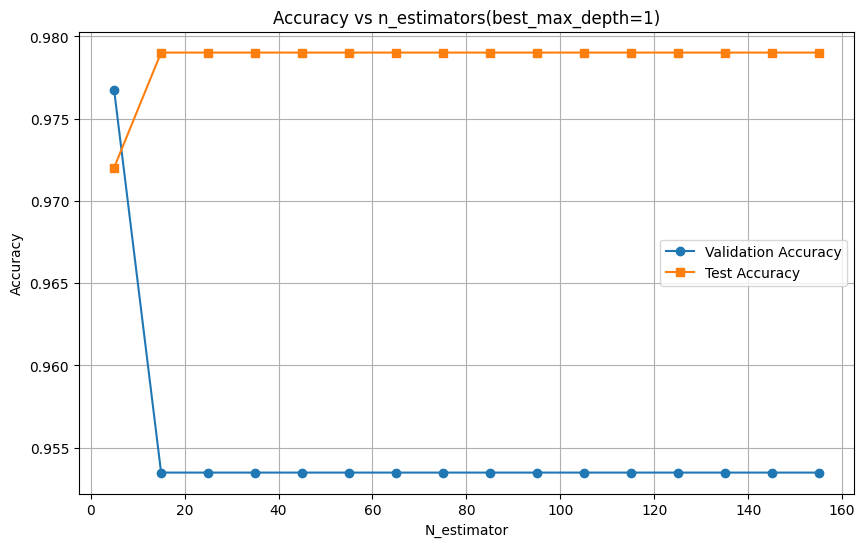


Validation Accuracies: [0.9767441860465116, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233]
Test Accuracies: [0.972027972027972, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791, 0.9790209790209791]


In [37]:
# Create lists to store results
n_estimators = range(5, 156, 10)
val_accuracies = []
test_accuracies = []

# Iterate over max_depths
for n_estimator in n_estimators:
    # Create and fit the model
    model = AdaBoost(n_estimators=n_estimator,max_depth=best_max_depth)
    model.fit(X_train_scaled, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies.append(val_acc)
    
    # Calculate test accuracy
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_acc)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(n_estimators, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('N_estimator')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs n_estimators(best_max_depth={best_max_depth})')
plt.legend()
plt.grid(True)
plt.show()

# Print the accuracies
print("\nValidation Accuracies:", val_accuracies)
print("Test Accuracies:", test_accuracies)




In [38]:
from sklearn.pipeline import Pipeline
dt_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeClassifier(max_depth=best_max_depth,  # Using same max_depth as AB 
                                      criterion='gini',
                                      random_state=10))
    ])
dt_pipeline.fit(X_train_val,y_train_val)
y_pred_dt = dt_pipeline.predict(X_test)
accurcy_dt = accuracy_score(y_test,y_pred_dt)
accurcy_dt

0.8951048951048951

In [39]:
import joblib

rf_params = joblib.load('best_random_forest_model.pkl')
rf_params

{'rf__criterion': 'gini',
 'rf__max_depth': np.int64(11),
 'rf__max_features': np.int64(6),
 'rf__n_estimators': np.int64(75)}

Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.
Perfect fit achieved at iteration 0. This may indicate a problem.


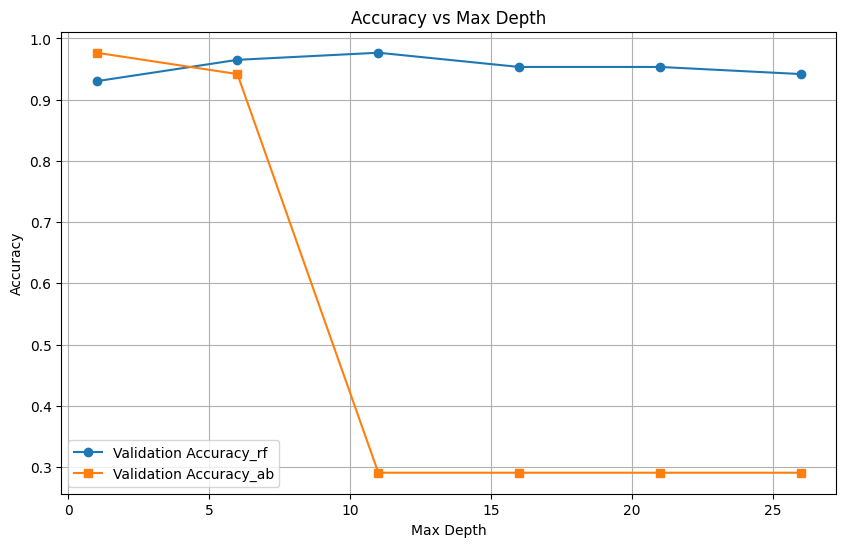

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

best_n_estimators_rf = rf_params['rf__n_estimators']
best_max_features_rf = rf_params['rf__max_features']
best_max_depth_rf = rf_params['rf__max_depth']

# Create lists to store results
max_depths = np.arange(1, 27, 5)
val_accuracies_rf = []
val_accuracies_ab = []
# Iterate over max_depths
for max_depth in max_depths:
    # Create and fit the model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=best_n_estimators_rf, 
                                      max_features=best_max_features_rf, 
                                      max_depth=max_depth, 
                                      criterion='gini'))
    ])
    model.fit(X_train, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies_rf.append(val_acc)
 

# Iterate over max_depths
for max_depth in max_depths:
    # Create and fit the model
    model = AdaBoost(n_estimators=best_n_estimators,max_depth=max_depth)
    model.fit(X_train_scaled, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies_ab.append(val_acc)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(max_depths, val_accuracies_rf, marker='o', label='Validation Accuracy_rf')
plt.plot(max_depths, val_accuracies_ab, marker='s', label='Validation Accuracy_ab')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()


Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10
Early stopping triggered at iteration 10


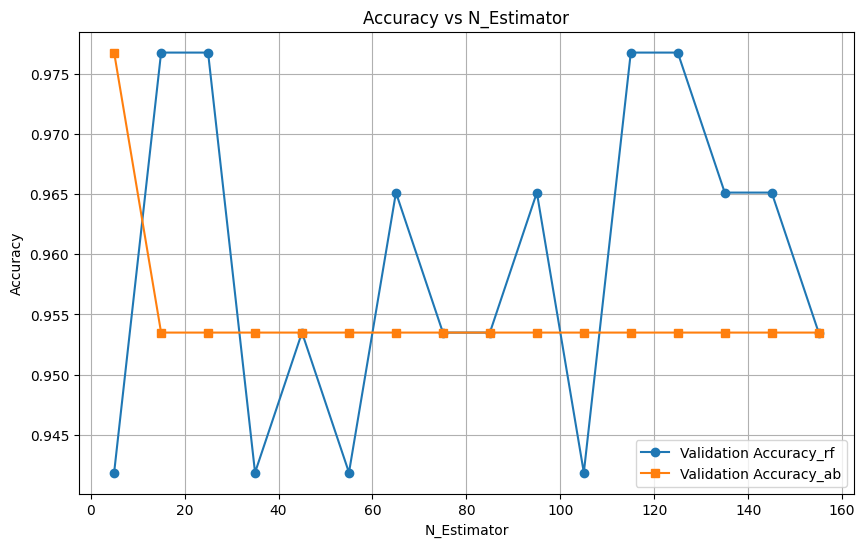

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

best_n_estimators_rf = rf_params['rf__n_estimators']
best_max_features_rf = rf_params['rf__max_features']
best_max_depth_rf = rf_params['rf__max_depth']

# Create lists to store results
n_estimators = range(5, 156, 10)
val_accuracies_rf = []
val_accuracies_ab = []
# Iterate over max_depths rf
for n_estimator in n_estimators:
    # Create and fit the model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=n_estimator, 
                                      max_depth=best_max_depth_rf, 
                                      max_features=best_max_features_rf, 
                                      criterion='gini'))
    ])
    model.fit(X_train, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies_rf.append(val_acc)

# Iterate over max_depths ab
for n_estimator in n_estimators:
    # Create and fit the model
    model = AdaBoost(n_estimators=n_estimator,max_depth=best_max_depth)
    model.fit(X_train_scaled, y_train)
    
    # Calculate validation accuracy
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    val_accuracies_ab.append(val_acc)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, val_accuracies_rf, marker='o', label='Validation Accuracy_rf')
plt.plot(n_estimators, val_accuracies_ab, marker='s', label='Validation Accuracy_ab')
plt.xlabel('N_Estimator')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs N_Estimator')
plt.legend()
plt.grid(True)
plt.show()
